## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

In [2]:
def seir(t, y, p):
    b = p[0]
    a = g =1/8
    return [
        -b*y[0]*y[2]/sum(y),
        b*y[0]*y[2]/sum(y) - g*y[1],
        g*y[1] - a*y[2],
        g*y[1]
    ]

In [3]:
cases = pd.read_csv("data/samoa_cases.csv", header=0, parse_dates=["Date"], dayfirst=True)
raw_times = cases["Date"].to_numpy()
raw_times = [(t-raw_times[0])/np.timedelta64(1,'D') for t in raw_times] # convert to days since first timestamp
raw_data = cases['Cases'].to_numpy()
raw_cumdata = np.cumsum(raw_data)

In [4]:
start = 1
clip = 5
times = raw_times[start:(-clip if clip else None)]
data = raw_data[start:(-clip if clip else None)]
cumdata = raw_cumdata[start:(-clip if clip else None)]

In [5]:
additional_times = [33,35,56,60,68, 75,83,86,87,89,90,91,92, 93,94,95]
additional_cumdata = [28,36,169,314,513, 716,1174,1644,1797,2194,2437,2686,2936, 3149,3357,3530]

# times = times + additional_times
# cumdata = np.concatenate([cumdata,additional_cumdata])
times = np.array(additional_times)
cumdata = np.array(additional_cumdata)

Text(0.5, 0, 'Days after 28 August 2019')

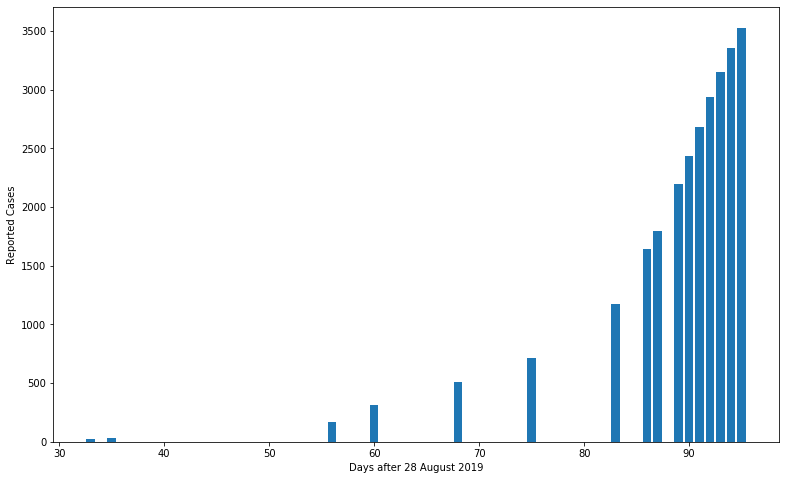

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

In [7]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1.5]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 4,
        "parameters": 1
    },
    "time_span": [times[0], times[-1]],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*4,
        times
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
# config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(4)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*4) + [0]*len(config['regularisation_value'])
alpha = 1e2

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     9600
Number of nonzeros in Lagrangian Hessian.............:     4753

Total number of variables............................:       97
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

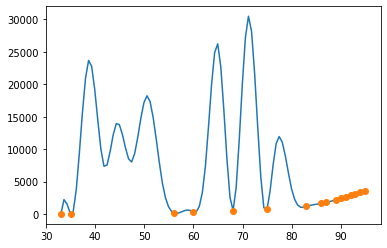

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(times, cumdata, 'o')

In [13]:
lbg = [0]*len(model.observation_times)*config['model_form']['state']
ubg = [150000]*len(model.observation_times)*config['model_form']['state']
# lbg[0] = 150000

In [14]:
prange = np.logspace(-6, 8, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
#         'ubg': ubg
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     9600
Number of nonzeros in Lagrangian Hessian.............:     4753

Total number of variables............................:       97
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

  37  3.2844445e+04 0.00e+00 1.40e-05  -5.7 4.12e+01    -  1.00e+00 1.00e+00h  1
  38  3.2844445e+04 0.00e+00 1.48e-05  -8.6 3.42e+02    -  9.84e-01 1.00e+00f  1
  39  3.2844445e+04 0.00e+00 6.22e-06  -8.6 9.17e+01    -  1.00e+00 6.42e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.2844445e+04 0.00e+00 9.98e-07  -8.6 5.48e+01    -  9.29e-01 1.00e+00f  1
  41  3.2844445e+04 0.00e+00 2.29e-07  -8.6 9.42e+00    -  1.00e+00 8.00e-01h  1
  42  3.2844445e+04 0.00e+00 7.91e-09  -8.6 2.88e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   3.2844444837935131e+04    3.2844444837935131e+04
Dual infeasibility......:   7.9084056594124616e-09    7.9084056594124616e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.5693427950829126e-09    3.5693427950829126e-09
Overall NLP error......

  12  3.2844481e+04 0.00e+00 4.61e-03  -3.8 2.47e+03    -  9.43e-01 1.00e+00f  1
  13  3.2844466e+04 0.00e+00 8.45e-03  -3.8 1.24e+03    -  1.00e+00 1.00e+00f  1
  14  3.2844464e+04 0.00e+00 4.93e-05  -3.8 3.97e+02    -  1.00e+00 1.00e+00f  1
  15  3.2844451e+04 0.00e+00 3.97e-03  -5.7 3.79e+03    -  9.26e-01 1.00e+00f  1
  16  3.2844449e+04 0.00e+00 1.15e-04  -5.7 1.33e+03    -  9.94e-01 1.00e+00f  1
  17  3.2844449e+04 0.00e+00 8.78e-05  -5.7 5.28e+02    -  1.00e+00 1.00e+00f  1
  18  3.2844448e+04 0.00e+00 7.67e-06  -5.7 1.30e+02    -  1.00e+00 1.00e+00f  1
  19  3.2844448e+04 0.00e+00 1.59e-05  -8.6 2.28e+02    -  9.89e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.2844448e+04 0.00e+00 1.99e-06  -8.6 5.63e+01    -  9.10e-01 1.00e+00h  1
  21  3.2844448e+04 0.00e+00 2.53e-07  -8.6 1.65e+01    -  8.70e-01 1.00e+00h  1
  22  3.2844448e+04 0.00e+00 2.28e-08  -8.6 3.58e+00    -  1.00e+00 1.00e+00h  1
  23  3.2844448e+04 0.00e+00

   6  3.2844861e+04 0.00e+00 1.73e-01  -1.0 3.75e+02    -  4.98e-01 1.00e+00f  1
   7  3.2845782e+04 0.00e+00 2.61e-01  -1.0 7.47e+02    -  8.03e-01 1.00e+00f  1
   8  3.2845479e+04 0.00e+00 5.67e-02  -1.7 1.04e+03    -  8.36e-01 1.00e+00f  1
   9  3.2844858e+04 0.00e+00 2.03e-01  -2.5 1.78e+03    -  8.21e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2844723e+04 0.00e+00 2.15e-02  -2.5 5.41e+03    -  6.85e-01 1.00e+00f  1
  11  3.2844540e+04 0.00e+00 7.49e-03  -3.8 1.13e+03    -  8.95e-01 1.00e+00f  1
  12  3.2844486e+04 0.00e+00 3.63e-04  -3.8 2.65e+03    -  1.00e+00 1.00e+00f  1
  13  3.2844461e+04 0.00e+00 3.20e-03  -5.7 3.35e+03    -  9.15e-01 1.00e+00f  1
  14  3.2844456e+04 0.00e+00 1.02e-03  -5.7 1.25e+03    -  9.79e-01 1.00e+00f  1
  15  3.2844455e+04 0.00e+00 2.31e-04  -5.7 5.40e+02    -  1.00e+00 1.00e+00f  1
  16  3.2844455e+04 0.00e+00 3.99e-05  -5.7 2.04e+02    -  1.00e+00 1.00e+00f  1
  17  3.2844455e+04 0.00e+00

  10  3.2845115e+04 0.00e+00 4.05e-01  -2.5 8.27e+03    -  5.31e-01 1.00e+00f  1
  11  3.2844807e+04 0.00e+00 8.07e-02  -2.5 1.88e+03    -  9.98e-01 1.00e+00f  1
  12  3.2844807e+04 0.00e+00 2.96e-03  -2.5 2.50e+04    -  8.86e-02 4.44e-02f  3
  13  3.2844548e+04 0.00e+00 1.78e-02  -3.8 7.24e+03    -  8.34e-01 1.00e+00f  1
  14  3.2844495e+04 0.00e+00 1.07e-03  -3.8 2.86e+03    -  1.00e+00 1.00e+00f  1
  15  3.2844473e+04 0.00e+00 1.91e-03  -5.7 2.34e+03    -  9.46e-01 1.00e+00f  1
  16  3.2844469e+04 0.00e+00 1.43e-04  -5.7 8.45e+02    -  9.89e-01 1.00e+00f  1
  17  3.2844468e+04 0.00e+00 4.67e-05  -5.7 3.25e+02    -  1.00e+00 1.00e+00f  1
  18  3.2844468e+04 0.00e+00 1.23e-05  -5.7 9.36e+01    -  1.00e+00 1.00e+00f  1
  19  3.2844468e+04 0.00e+00 1.01e-05  -8.6 9.38e+01    -  9.95e-01 6.18e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.2844468e+04 0.00e+00 5.44e-06  -8.6 5.40e+01    -  9.40e-01 1.00e+00f  1
  21  3.2844468e+04 0.00e+00

   4  3.2844540e+04 0.00e+00 1.64e-02  -1.0 5.06e+01    -  5.53e-01 1.00e+00f  1
   5  3.2844709e+04 0.00e+00 7.92e-02  -1.0 1.12e+02    -  6.84e-01 1.00e+00f  1
   6  3.2845610e+04 0.00e+00 4.25e-01  -1.0 3.71e+02    -  5.35e-01 1.00e+00f  1
   7  3.2847156e+04 0.00e+00 2.54e-01  -1.0 8.48e+02    -  8.95e-01 1.00e+00f  1
   8  3.2846158e+04 0.00e+00 4.09e-01  -1.7 2.46e+03    -  8.12e-01 1.00e+00f  1
   9  3.2846341e+04 0.00e+00 3.23e-01  -1.7 8.53e+03    -  6.31e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2846652e+04 0.00e+00 9.21e-01  -1.7 1.20e+04    -  7.68e-01 1.00e+00f  1
  11  3.2847215e+04 0.00e+00 3.60e-01  -1.7 7.03e+03    -  1.00e+00 1.00e+00f  1
  12  3.2847148e+04 0.00e+00 7.74e-01  -1.7 2.35e+03    -  1.00e+00 1.00e+00f  1
  13  3.2847158e+04 0.00e+00 5.98e-02  -1.7 1.44e+03    -  1.00e+00 1.00e+00f  1
  14  3.2845363e+04 0.00e+00 3.21e-01  -2.5 1.25e+04    -  7.45e-01 1.00e+00f  1
  15  3.2844928e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2846778e+04 0.00e+00 1.03e+00  -1.7 8.21e+03    -  8.17e-01 1.00e+00f  1
  11  3.2847151e+04 0.00e+00 3.42e-02  -1.7 3.34e+03    -  1.00e+00 1.00e+00f  1
  12  3.2845322e+04 0.00e+00 1.08e-01  -2.5 9.48e+03    -  8.95e-01 1.00e+00f  1
  13  3.2844921e+04 0.00e+00 1.16e-02  -2.5 3.70e+03    -  1.00e+00 1.00e+00f  1
  14  3.2844792e+04 0.00e+00 3.55e-01  -3.8 6.19e+03    -  7.02e-01 6.04e-01f  1
  15  3.2844585e+04 0.00e+00 4.73e-03  -3.8 2.88e+03    -  6.06e-02 1.00e+00f  1
  16  3.2844558e+04 0.00e+00 3.13e-03  -3.8 7.60e+02    -  4.87e-01 1.00e+00f  1
  17  3.2844552e+04 0.00e+00 1.68e-04  -3.8 3.13e+02    -  1.00e+00 1.00e+00f  1
  18  3.2844542e+04 0.00e+00 2.53e-04  -5.7 8.17e+02    -  9.75e-01 1.00e+00f  1
  19  3.2844541e+04 0.00e+00 3.27e-04  -5.7 2.46e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.2844541e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2847053e+04 0.00e+00 1.35e+00  -1.7 5.25e+03    -  8.75e-01 1.00e+00f  1
  11  3.2847095e+04 0.00e+00 6.62e-02  -1.7 9.43e+02    -  1.00e+00 1.00e+00f  1
  12  3.2845341e+04 0.00e+00 1.64e-01  -2.5 7.00e+03    -  9.57e-01 1.00e+00f  1
  13  3.2844970e+04 0.00e+00 4.09e-02  -2.5 2.86e+03    -  1.00e+00 1.00e+00f  1
  14  3.2844910e+04 0.00e+00 3.45e-02  -2.5 6.15e+02    -  1.00e+00 1.00e+00f  1
  15  3.2844906e+04 0.00e+00 7.38e-03  -2.5 1.27e+02    -  1.00e+00 1.00e+00f  1
  16  3.2844723e+04 0.00e+00 2.85e-01  -3.8 3.27e+03    -  8.74e-01 1.00e+00f  1
  17  3.2844649e+04 0.00e+00 2.75e-02  -3.8 8.39e+02    -  7.74e-01 1.00e+00f  1
  18  3.2844641e+04 0.00e+00 1.78e-03  -3.8 2.72e+02    -  1.00e+00 1.00e+00f  1
  19  3.2844640e+04 0.00e+00 1.99e-05  -3.8 4.87e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.2844633e+04 0.00e+00

   1  3.2844808e+04 0.00e+00 1.83e-02  -1.0 2.97e-01    -  9.82e-01 1.00e+00f  1
   2  3.2844820e+04 0.00e+00 9.06e-02  -1.0 1.61e+01    -  2.66e-01 1.00e+00f  1
   3  3.2844869e+04 0.00e+00 2.00e-02  -1.0 2.12e+01    -  5.56e-01 1.00e+00f  1
   4  3.2845090e+04 0.00e+00 1.05e-01  -1.0 5.98e+01    -  5.64e-01 1.00e+00f  1
   5  3.2845863e+04 0.00e+00 3.22e-01  -1.0 1.78e+02    -  7.59e-01 1.00e+00f  1
   6  3.2847664e+04 0.00e+00 4.10e-01  -1.0 7.50e+02    -  7.52e-01 1.00e+00f  1
   7  3.2846124e+04 0.00e+00 4.81e-01  -1.7 8.12e+02    -  8.73e-01 1.00e+00f  1
   8  3.2846415e+04 0.00e+00 1.46e-01  -1.7 3.36e+03    -  8.26e-01 1.00e+00f  1
   9  3.2845343e+04 0.00e+00 1.10e-01  -2.5 7.39e+02    -  9.56e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2845091e+04 0.00e+00 3.41e-04  -2.5 9.99e+02    -  1.00e+00 1.00e+00f  1
  11  3.2844865e+04 0.00e+00 6.24e-02  -3.8 2.15e+03    -  9.96e-01 1.00e+00f  1
  12  3.2844822e+04 0.00e+00

   3  3.2845256e+04 0.00e+00 4.06e-02  -1.0 2.49e+01    -  5.58e-01 1.00e+00f  1
   4  3.2845628e+04 0.00e+00 1.74e-01  -1.0 7.75e+01    -  5.75e-01 1.00e+00f  1
   5  3.2846678e+04 0.00e+00 3.88e-01  -1.0 2.23e+02    -  8.31e-01 1.00e+00f  1
   6  3.2848508e+04 0.00e+00 1.55e-02  -1.0 1.10e+03    -  6.59e-01 1.00e+00f  1
   7  3.2846798e+04 0.00e+00 4.87e-01  -1.7 8.09e+02    -  8.99e-01 1.00e+00f  1
   8  3.2846790e+04 0.00e+00 2.94e-01  -1.7 3.06e+03    -  9.02e-01 1.00e+00f  1
   9  3.2847325e+04 0.00e+00 1.57e+00  -1.7 2.29e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2847262e+04 0.00e+00 2.29e-03  -1.7 2.62e+02    -  1.00e+00 1.00e+00f  1
  11  3.2845582e+04 0.00e+00 4.79e-01  -3.8 4.59e+03    -  9.05e-01 1.00e+00f  1
  12  3.2845230e+04 0.00e+00 4.14e-03  -3.8 1.67e+03    -  9.70e-01 1.00e+00f  1
  13  3.2845163e+04 0.00e+00 4.19e-02  -3.8 7.20e+02    -  1.00e+00 1.00e+00f  1
  14  3.2845151e+04 0.00e+00

   5  3.2847759e+04 0.00e+00 3.56e-01  -1.0 2.71e+02    -  9.29e-01 1.00e+00f  1
   6  3.2846796e+04 0.00e+00 2.16e-01  -1.7 8.54e+02    -  8.30e-01 1.00e+00f  1
   7  3.2847229e+04 0.00e+00 9.94e-02  -1.7 1.71e+03    -  9.18e-01 1.00e+00f  1
   8  3.2846219e+04 0.00e+00 7.46e-02  -2.5 1.03e+03    -  1.00e+00 1.00e+00f  1
   9  3.2846000e+04 0.00e+00 8.89e-03  -2.5 5.27e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2845828e+04 0.00e+00 5.81e-03  -3.8 9.29e+02    -  1.00e+00 1.00e+00f  1
  11  3.2845799e+04 0.00e+00 4.77e-03  -3.8 2.68e+02    -  1.00e+00 1.00e+00f  1
  12  3.2845795e+04 0.00e+00 3.91e-04  -3.8 6.75e+01    -  1.00e+00 1.00e+00f  1
  13  3.2845792e+04 0.00e+00 7.20e-04  -5.7 1.25e+02    -  1.00e+00 7.59e-01f  1
  14  3.2845791e+04 0.00e+00 2.92e-04  -5.7 5.49e+01    -  9.62e-01 1.00e+00f  1
  15  3.2845791e+04 0.00e+00 4.72e-05  -5.7 8.99e+00    -  1.00e+00 8.78e-01f  1
  16  3.2845791e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2847342e+04 0.00e+00 8.51e-01  -3.8 2.18e+03    -  9.35e-01 1.00e+00f  1
  11  3.2847083e+04 0.00e+00 3.92e-02  -3.8 6.73e+02    -  9.66e-01 1.00e+00f  1
  12  3.2847040e+04 0.00e+00 6.30e-03  -3.8 2.38e+02    -  1.00e+00 1.00e+00f  1
  13  3.2847033e+04 0.00e+00 9.50e-04  -3.8 7.21e+01    -  1.00e+00 1.00e+00f  1
  14  3.2847031e+04 0.00e+00 7.68e-04  -5.7 8.06e+01    -  1.00e+00 6.01e-01f  1
  15  3.2847030e+04 0.00e+00 4.36e-04  -5.7 4.79e+01    -  9.75e-01 1.00e+00f  1
  16  3.2847030e+04 0.00e+00 6.83e-05  -5.7 5.30e+00    -  1.00e+00 8.67e-01f  1
  17  3.2847030e+04 0.00e+00 1.20e-06  -5.7 1.29e+00    -  1.00e+00 1.00e+00f  1
  18  3.2847030e+04 0.00e+00 8.34e-07  -8.6 1.70e+00    -  9.98e-01 9.42e-01h  1
  19  3.2847030e+04 0.00e+00 6.72e-09  -8.6 1.28e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objecti

  13  3.2849558e+04 0.00e+00 2.49e-02  -2.5 3.15e+02    -  1.00e+00 1.00e+00f  1
  14  3.2849428e+04 0.00e+00 2.51e-02  -3.8 3.97e+02    -  1.00e+00 1.00e+00f  1
  15  3.2849410e+04 0.00e+00 3.61e-03  -3.8 1.07e+02    -  1.00e+00 1.00e+00f  1
  16  3.2849408e+04 0.00e+00 2.76e-04  -3.8 2.21e+01    -  1.00e+00 1.00e+00f  1
  17  3.2849406e+04 0.00e+00 5.56e-04  -5.7 4.69e+01    -  9.85e-01 8.71e-01f  1
  18  3.2849405e+04 0.00e+00 1.83e-04  -5.7 1.47e+01    -  1.00e+00 7.88e-01f  1
  19  3.2849405e+04 0.00e+00 1.38e-05  -5.7 4.03e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.2849405e+04 0.00e+00 1.56e-06  -8.6 1.08e+00    -  9.97e-01 9.40e-01h  1
  21  3.2849405e+04 0.00e+00 6.25e-09  -8.6 8.13e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   3.2849405416672678e+04    3.2849405416672678e+04
Dual infeas

  11  3.2853969e+04 0.00e+00 9.52e-03  -3.8 8.78e+01    -  1.00e+00 8.12e-01f  1
  12  3.2853964e+04 0.00e+00 1.15e-03  -3.8 3.54e+01    -  1.00e+00 1.00e+00f  1
  13  3.2853962e+04 0.00e+00 6.06e-04  -5.7 3.04e+01    -  9.26e-01 9.18e-01f  1
  14  3.2853961e+04 0.00e+00 2.10e-04  -5.7 7.11e+00    -  1.00e+00 7.11e-01f  1
  15  3.2853961e+04 0.00e+00 1.26e-05  -5.7 2.58e+00    -  1.00e+00 1.00e+00f  1
  16  3.2853961e+04 0.00e+00 7.59e-07  -8.6 5.41e-01    -  1.00e+00 9.70e-01h  1
  17  3.2853961e+04 0.00e+00 7.67e-10  -8.6 2.07e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   3.2853961385734961e+04    3.2853961385734961e+04
Dual infeasibility......:   7.6725235505959532e-10    7.6725235505959532e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6451582836815329e-09    2.6451582836815329e-09
Overall NLP error......

  15  3.2862697e+04 0.00e+00 5.35e-05  -5.7 4.50e+00    -  1.00e+00 1.00e+00f  1
  16  3.2862697e+04 0.00e+00 5.41e-07  -5.7 2.87e-01    -  1.00e+00 1.00e+00h  1
  17  3.2862697e+04 0.00e+00 1.35e-07  -8.6 2.46e-01    -  1.00e+00 9.91e-01h  1
  18  3.2862697e+04 0.00e+00 2.81e-10  -8.6 2.92e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   3.2862696848756219e+04    3.2862696848756219e+04
Dual infeasibility......:   2.8098245117846152e-10    2.8098245117846152e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5099772447641932e-09    2.5099772447641932e-09
Overall NLP error.......:   2.5099772447641932e-09    2.5099772447641932e-09


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 19
Number of equality constraint evaluations            = 0
Number of ineq

  15  3.2879442e+04 0.00e+00 3.19e-05  -5.7 2.58e+00    -  1.00e+00 1.00e+00f  1
  16  3.2879442e+04 0.00e+00 5.05e-08  -5.7 5.92e-02    -  1.00e+00 1.00e+00h  1
  17  3.2879442e+04 0.00e+00 6.38e-08  -8.6 1.27e-01    -  1.00e+00 9.96e-01h  1
  18  3.2879442e+04 0.00e+00 9.47e-10  -8.6 6.39e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   3.2879441587360881e+04    3.2879441587360881e+04
Dual infeasibility......:   9.4718560004254351e-10    9.4718560004254351e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062991488617234e-09    2.5062991488617234e-09
Overall NLP error.......:   2.5062991488617234e-09    2.5062991488617234e-09


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 19
Number of equality constraint evaluations            = 0
Number of ineq

   1  3.2937294e+04 0.00e+00 1.82e-02  -1.0 4.99e-01    -  9.82e-01 1.00e+00f  1
   2  3.2937892e+04 0.00e+00 7.31e-01  -1.0 7.90e+01    -  3.52e-01 1.00e+00f  1
   3  3.2938546e+04 0.00e+00 6.27e-02  -1.0 9.05e+01    -  8.43e-01 1.00e+00f  1
   4  3.2940482e+04 0.00e+00 5.31e-01  -1.0 2.64e+02    -  9.28e-01 1.00e+00f  1
   5  3.2938328e+04 0.00e+00 3.10e-02  -1.7 9.87e+01    -  1.00e+00 1.00e+00f  1
   6  3.2937452e+04 0.00e+00 5.96e-02  -2.5 2.21e+02    -  1.00e+00 1.00e+00f  1
   7  3.2937340e+04 0.00e+00 1.59e-02  -2.5 5.15e+01    -  1.00e+00 1.00e+00f  1
   8  3.2937297e+04 0.00e+00 1.13e-02  -3.8 4.90e+01    -  1.00e+00 1.00e+00f  1
   9  3.2937292e+04 0.00e+00 2.06e-03  -3.8 1.03e+01    -  1.00e+00 9.04e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2937292e+04 0.00e+00 8.48e-05  -3.8 1.91e+00    -  1.00e+00 1.00e+00f  1
  11  3.2937291e+04 0.00e+00 1.12e-04  -5.7 3.78e+00    -  1.00e+00 9.12e-01f  1
  12  3.2937291e+04 0.00e+00

   2  3.3091019e+04 0.00e+00 7.56e-01  -1.0 8.37e+01    -  5.03e-01 1.00e+00f  1
   3  3.3091779e+04 0.00e+00 2.04e-01  -1.0 8.23e+01    -  8.76e-01 1.00e+00f  1
   4  3.3094111e+04 0.00e+00 1.02e+00  -1.0 1.92e+02    -  9.73e-01 1.00e+00f  1
   5  3.3094473e+04 0.00e+00 9.50e-01  -1.0 9.55e+01    -  1.00e+00 1.00e+00f  1
   6  3.3091101e+04 0.00e+00 3.68e+00  -1.7 2.78e+02    -  1.00e+00 1.00e+00f  1
   7  3.3090723e+04 0.00e+00 9.73e-03  -1.7 4.45e+01    -  1.00e+00 1.00e+00f  1
   8  3.3090380e+04 0.00e+00 5.58e-02  -3.8 1.05e+02    -  1.00e+00 6.65e-01f  1
   9  3.3090266e+04 0.00e+00 1.52e-02  -3.8 5.35e+01    -  9.74e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.3090261e+04 0.00e+00 4.45e-03  -3.8 6.38e+00    -  1.00e+00 7.66e-01f  1
  11  3.3090260e+04 0.00e+00 2.63e-04  -3.8 2.09e+00    -  1.00e+00 1.00e+00f  1
  12  3.3090260e+04 0.00e+00 5.93e-05  -5.7 1.54e+00    -  1.00e+00 9.52e-01f  1
  13  3.3090260e+04 0.00e+00

   5  3.3494813e+04 0.00e+00 4.34e-02  -1.0 8.59e+00    -  1.00e+00 1.00e+00f  1
   6  3.3492435e+04 0.00e+00 4.55e+00  -2.5 1.81e+02    -  1.00e+00 7.58e-01f  1
   7  3.3491898e+04 0.00e+00 2.53e-01  -2.5 6.97e+01    -  1.00e+00 1.00e+00f  1
   8  3.3491851e+04 0.00e+00 6.12e-03  -2.5 1.03e+01    -  1.00e+00 1.00e+00f  1
   9  3.3491836e+04 0.00e+00 1.50e-03  -3.8 9.95e+00    -  1.00e+00 7.87e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.3491834e+04 0.00e+00 4.63e-04  -5.7 3.31e+00    -  1.00e+00 9.99e-01f  1
  11  3.3491834e+04 0.00e+00 2.49e-06  -5.7 9.99e-02    -  1.00e+00 1.00e+00f  1
  12  3.3491834e+04 0.00e+00 1.93e-09  -8.6 7.96e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   3.3491833696873626e+04    3.3491833696873626e+04
Dual infeasibility......:   1.9340644701621974e-09    1.9340644701621974e-09
Constraint viol

  10  3.4526557e+04 0.00e+00 1.55e-05  -3.8 3.73e-01    -  1.00e+00 1.00e+00f  1
  11  3.4526557e+04 0.00e+00 7.30e-06  -5.7 2.31e-01    -  1.00e+00 1.00e+00f  1
  12  3.4526557e+04 0.00e+00 3.90e-10  -8.6 3.34e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   3.4526557087101930e+04    3.4526557087101930e+04
Dual infeasibility......:   3.8984540206138070e-10    3.8984540206138070e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0618094405126954e-09    3.0618094405126954e-09
Overall NLP error.......:   3.0618094405126954e-09    3.0618094405126954e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobia

   2  3.7070970e+04 0.00e+00 1.44e+00  -1.0 2.16e+01    -  9.64e-01 1.00e+00f  1
   3  3.7071734e+04 0.00e+00 3.98e+00  -1.0 2.90e+01    -  1.00e+00 1.00e+00f  1
   4  3.7071692e+04 0.00e+00 2.06e-02  -1.0 1.86e+00    -  1.00e+00 1.00e+00f  1
   5  3.7070685e+04 0.00e+00 2.26e+00  -2.5 4.29e+01    -  9.87e-01 7.25e-01f  1
   6  3.7070474e+04 0.00e+00 5.37e-01  -2.5 1.63e+01    -  1.00e+00 8.29e-01f  1
   7  3.7070461e+04 0.00e+00 2.73e-03  -2.5 3.29e+00    -  1.00e+00 1.00e+00f  1
   8  3.7070453e+04 0.00e+00 2.09e-03  -3.8 1.66e+00    -  1.00e+00 9.85e-01f  1
   9  3.7070453e+04 0.00e+00 1.56e-06  -3.8 5.03e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.7070453e+04 0.00e+00 6.88e-06  -5.7 8.96e-02    -  1.00e+00 1.00e+00f  1
  11  3.7070453e+04 0.00e+00 9.37e-10  -8.6 1.18e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objecti

   5  4.2678335e+04 0.00e+00 1.03e-03  -1.0 1.79e-01    -  1.00e+00 1.00e+00f  1
   6  4.2677653e+04 0.00e+00 3.98e+00  -2.5 2.27e+01    -  9.91e-01 8.87e-01f  1
   7  4.2677613e+04 0.00e+00 1.77e-01  -2.5 4.67e+00    -  1.00e+00 1.00e+00f  1
   8  4.2677611e+04 0.00e+00 7.22e-04  -2.5 2.66e-01    -  1.00e+00 1.00e+00f  1
   9  4.2677608e+04 0.00e+00 6.14e-03  -3.8 8.08e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2677608e+04 0.00e+00 5.89e-07  -3.8 7.09e-03    -  1.00e+00 1.00e+00f  1
  11  4.2677608e+04 0.00e+00 1.94e-05  -5.7 4.54e-02    -  1.00e+00 1.00e+00f  1
  12  4.2677608e+04 0.00e+00 8.39e-10  -5.7 2.32e-05    -  1.00e+00 1.00e+00h  1
  13  4.2677608e+04 0.00e+00 3.00e-09  -8.6 5.63e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   4.2677607664801712e+04    4.2677607664801712e+04
Dual infeas

   8  5.2649707e+04 0.00e+00 1.37e-03  -3.8 2.78e-01    -  1.00e+00 1.00e+00f  1
   9  5.2649707e+04 0.00e+00 4.27e-06  -5.7 1.53e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2649707e+04 0.00e+00 7.35e-10  -8.6 1.85e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   5.2649706722060553e+04    5.2649706722060553e+04
Dual infeasibility......:   7.3474988562864401e-10    7.3474988562864401e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5207098504083535e-09    2.5207098504083535e-09
Overall NLP error.......:   2.5207098504083535e-09    2.5207098504083535e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 0
Number of ineq

   1  7.0931602e+04 0.00e+00 1.76e+02  -1.0 5.99e+01    -  9.16e-01 1.00e+00f  1
   2  7.0928122e+04 0.00e+00 2.12e+02  -1.0 2.26e+01    -  9.61e-01 1.00e+00f  1
   3  7.0927987e+04 0.00e+00 2.15e+01  -1.0 7.73e+00    -  9.95e-01 1.00e+00f  1
   4  7.0927989e+04 0.00e+00 4.29e-02  -1.0 2.85e-01    -  1.00e+00 1.00e+00f  1
   5  7.0927809e+04 0.00e+00 7.99e-01  -2.5 2.74e+00    -  1.00e+00 9.60e-01f  1
   6  7.0927811e+04 0.00e+00 1.25e-03  -2.5 1.43e-01    -  1.00e+00 1.00e+00f  1
   7  7.0927808e+04 0.00e+00 6.55e-04  -3.8 7.78e-02    -  1.00e+00 1.00e+00f  1
   8  7.0927808e+04 0.00e+00 2.02e-06  -5.7 4.34e-03    -  1.00e+00 1.00e+00f  1
   9  7.0927808e+04 0.00e+00 6.90e-10  -8.6 5.35e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   7.0927807960472899e+04    7.0927807960472899e+04
Dual infeasibility......:   6.8963868720722387e-10    6.8963868720722387e-10
Constraint viola

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.9860708e+04 0.00e+00 1.47e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  8.9324730e+04 0.00e+00 2.13e+02  -1.0 3.45e+01    -  9.56e-01 1.00e+00f  1
   2  8.9323835e+04 0.00e+00 8.14e+01  -1.0 8.42e+00    -  9.85e-01 1.00e+00f  1
   3  8.9323839e+04 0.00e+00 6.09e-01  -1.0 7.65e-01    -  1.00e+00 1.00e+00f  1
   4  8.9323727e+04 0.00e+00 3.02e-01  -1.7 9.13e-01    -  1.00e+00 1.00e+00f  1
   5  8.9323728e+04 0.00e+00 1.58e-06  -1.7 3.91e-03    -  1.00e+00 1.00e+00f  1
   6  8.9323707e+04 0.00e+00 1.89e-02  -3.8 2.29e-01    -  1.00e+00 1.00e+00f  1
   7  8.9323707e+04 0.00e+00 6.25e-09  -3.8 2.58e-04    -  1.00e+00 1.00e+00f  1
   8  8.9323707e+04 0.00e+00 1.06e-06  -5.7 1.72e-03    -  1.00e+00 1.00e+00f  1
   9  8.9323707e+04 0.00e+00 4.76e-10  -8.6 2.13e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objectiv

Total number of variables............................:       97
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7287818e+05 0.00e+00 5.23e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.7283372e+05 8.90e-03 4.71e+01  -1.0 8.62e+00    -  9.84e-01 9.98e-02f  1
   2  1.7264465e+05 0.00e+00 8.13e+01  -1.0 7.78e+00    -  9.91e-01 1.00e+00f  1
   3  1.7264465e+05 0.00e+00 8.14e-03  -1.0 2.45e-02    -  1.00e+00 1.00e+00f  1
   4  1.7264452e+0

   5  3.3264006e+05 0.00e+00 2.83e-08  -2.5 3.07e-04    -  1.00e+00 1.00e+00f  1
   6  3.3264005e+05 0.00e+00 1.17e-04  -3.8 8.00e-03    -  1.00e+00 1.00e+00f  1
   7  3.3264005e+05 0.00e+00 3.61e-07  -5.7 4.44e-04    -  1.00e+00 1.00e+00f  1
   8  3.3264005e+05 0.00e+00 4.48e-10  -8.6 5.51e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.0128081197554333e+05    3.3264005125351291e+05
Dual infeasibility......:   4.4787677927312665e-10    1.4709770973069048e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062443025235121e-09    8.2313442890501023e-09
Overall NLP error.......:   2.5062443025235121e-09    8.2313442890501023e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequal

   7  7.3225206e+05 0.00e+00 3.87e-07  -5.7 4.28e-04    -  1.00e+00 1.00e+00f  1
   8  7.3225206e+05 0.00e+00 3.81e-11  -8.6 5.31e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   8.8862385422585328e+04    7.3225205697716435e+05
Dual infeasibility......:   3.8117867704038496e-11    3.1410238315267538e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062132929785655e-09    2.0651930851055420e-08
Overall NLP error.......:   2.5062132929785655e-09    2.0651930851055420e-08


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 9
Number o

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6814751e+06 0.00e+00 5.18e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.6792760e+06 9.06e-03 4.75e+01  -1.0 1.68e+01    -  9.63e-01 8.44e-02f  1
   2  1.6677750e+06 0.00e+00 3.45e+03  -1.0 2.31e+01    -  9.74e-01 1.00e+00f  1
   3  1.6677684e+06 0.00e+00 1.86e-01  -1.0 6.01e-01    -  1.00e+00 1.00e+00f  1
   4  1.6677664e+06 0.00e+00 1.30e-01  -2.5 2.35e-01    -  1.00e+00 1.00e+00f  1
   5  1.6677664e+06 0.00e+00 2.83e-08  -2.5 1.23e-04    -  1.00e+00 1.00e+00f  1
   6  1.6677664e+06 0.00e+00 1.41e-04  -3.8 7.11e-03    -  1.00e+00 1.00e+00f  1
   7  1.6677664e+06 0.00e+00 4.33e-07  -5.7 3.95e-04    -  1.00e+00 1.00e+00f  1
   8  1.6677664e+06 0.00e+00 1.43e-09  -8.6 4.89e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   8.7378580095309604e+04    1.6677663711526450e+06
Dual infeasi

   2  3.6564093e+06 0.00e+00 1.94e+04  -1.0 4.54e+01    -  9.40e-01 1.00e+00f  1
   3  3.6561342e+06 0.00e+00 4.67e+00  -1.0 2.04e+00    -  9.95e-01 1.00e+00f  1
   4  3.6561341e+06 0.00e+00 1.45e+00  -1.0 3.93e-01    -  1.00e+00 1.00e+00f  1
   5  3.6561341e+06 0.00e+00 1.05e-06  -1.0 1.92e-04    -  1.00e+00 1.00e+00h  1
   6  3.6561303e+06 0.00e+00 2.29e-01  -2.5 2.28e-01    -  1.00e+00 1.00e+00f  1
   7  3.6561303e+06 0.00e+00 2.83e-08  -2.5 4.08e-05    -  1.00e+00 1.00e+00f  1
   8  3.6561302e+06 0.00e+00 1.74e-04  -3.8 6.28e-03    -  1.00e+00 1.00e+00f  1
   9  3.6561302e+06 0.00e+00 5.30e-07  -5.7 3.49e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6561302e+06 0.00e+00 3.64e-09  -8.6 4.32e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   9.5092102162730051e+04    3.6561301580647337e+06
Dual infeas

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     9600
Number of nonzeros in Lagrangian Hessian.............:     4753

Total number of variables............................:       97
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.5901368e+06 0.00e+00 5.27e+01  -1.0 0.00e+00    -  0.00e+00 0.

   8  1.1368925e+07 0.00e+00 5.49e-04  -3.8 7.46e-03    -  1.00e+00 1.00e+00f  1
   9  1.1368925e+07 0.00e+00 1.70e-06  -5.7 4.14e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1368925e+07 0.00e+00 2.20e-08  -8.6 5.14e-06    -  1.00e+00 1.00e+00h  1
  11  1.1368925e+07 0.00e+00 2.66e-09  -9.0 4.45e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.1400157775391851e+05    1.1368924535459846e+07
Dual infeasibility......:   2.6574454694643555e-09    2.6501648130393048e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090913239273e-10    9.0660025461301161e-08
Overall NLP error.......:   2.6574454694643555e-09    2.6501648130393048e-07


Number of objective function evaluations             = 12
Number of objective gradient evaluations        

   7  1.8453317e+07 0.00e+00 1.12e-06  -1.0 4.67e-05    -  1.00e+00 1.00e+00h  1
   8  1.8453301e+07 0.00e+00 2.82e+00  -2.5 4.81e-01    -  1.00e+00 1.00e+00f  1
   9  1.8453301e+07 0.00e+00 2.83e-08  -2.5 7.99e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8453300e+07 0.00e+00 2.14e-03  -3.8 1.33e-02    -  1.00e+00 1.00e+00f  1
  11  1.8453300e+07 0.00e+00 1.50e-09  -3.8 6.06e-08    -  1.00e+00 1.00e+00h  1
  12  1.8453300e+07 0.00e+00 6.59e-06  -5.7 7.35e-04    -  1.00e+00 1.00e+00f  1
  13  1.8453300e+07 0.00e+00 3.59e-09  -8.6 9.12e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   1.1499544807426940e+05    1.8453300163004573e+07
Dual infeasibility......:   3.5942654103592403e-09    5.7677116436841416e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

   3  2.4411691e+07 0.00e+00 2.56e+03  -1.0 1.37e+01    -  9.90e-01 1.00e+00f  1
   4  2.4411181e+07 0.00e+00 8.26e+04  -1.0 7.92e+01    -  1.00e+00 1.00e+00f  1
   5  2.4409372e+07 0.00e+00 5.01e+00  -1.0 3.54e-01    -  1.00e+00 1.00e+00f  1
   6  2.4409372e+07 0.00e+00 4.83e-01  -1.0 1.96e-01    -  1.00e+00 1.00e+00f  1
   7  2.4409349e+07 0.00e+00 1.05e+01  -1.7 9.18e-01    -  1.00e+00 1.00e+00f  1
   8  2.4409349e+07 0.00e+00 2.00e-07  -1.7 2.07e-04    -  1.00e+00 1.00e+00h  1
   9  2.4409344e+07 0.00e+00 6.47e-01  -3.8 2.28e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4409344e+07 0.00e+00 5.40e-08  -3.8 1.32e-05    -  1.00e+00 1.00e+00h  1
  11  2.4409344e+07 0.00e+00 3.63e-05  -5.7 1.70e-03    -  1.00e+00 1.00e+00f  1
  12  2.4409344e+07 0.00e+00 2.98e-08  -5.7 7.40e-10    -  1.00e+00 1.00e+00h  1
  13  2.4409344e+07 0.00e+00 6.11e-09  -8.6 2.11e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

  11  2.6933266e+07 0.00e+00 5.08e-08  -3.8 4.32e-07    -  1.00e+00 1.00e+00h  1
  12  2.6933266e+07 0.00e+00 1.06e-04  -5.7 2.59e-03    -  1.00e+00 1.00e+00f  1
  13  2.6933266e+07 0.00e+00 4.69e-08  -5.7 1.32e-09    -  1.00e+00 1.00e+00h  1
  14  2.6933266e+07 0.00e+00 6.08e-08  -8.6 3.21e-05    -  1.00e+00 1.00e+00h  1
  15  2.6933266e+07 0.00e+00 4.21e-08  -8.6 6.88e-12    -  1.00e+00 1.00e+00h  1
  16  2.6933266e+07 0.00e+00 5.26e-08  -8.6 4.33e-12    -  1.00e+00 1.00e+00h  1
  17  2.6933266e+07 0.00e+00 4.32e-08  -8.6 2.46e-12    -  1.00e+00 1.00e+00h  1
  18  2.6933266e+07 0.00e+00 3.69e-08  -8.6 2.45e-12    -  1.00e+00 5.00e-01h  2
  19  2.6933266e+07 0.00e+00 2.53e-08  -8.6 1.76e-12    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.6933266e+07 0.00e+00 3.61e-08  -8.6 2.86e-12    -  1.00e+00 1.00e+00h  1
  21  2.6933266e+07 0.00e+00 8.59e-08  -8.6 3.63e-12    -  1.00e+00 1.00e+00h  1
  22  2.6933266e+07 0.00e+00

  11  2.8469908e+07 0.00e+00 8.85e-08  -5.7 1.89e-09    -  1.00e+00 1.00e+00h  1
  12  2.8469908e+07 0.00e+00 3.75e-08  -8.6 4.37e-05    -  1.00e+00 1.00e+00h  1
  13  2.8469908e+07 0.00e+00 9.21e-08  -8.6 3.17e-12    -  1.00e+00 1.00e+00h  1
  14  2.8469908e+07 0.00e+00 1.48e-08  -8.6 4.35e-12    -  1.00e+00 1.00e+00h  1
  15  2.8469908e+07 0.00e+00 1.31e-07  -9.0 3.79e-08    -  1.00e+00 1.00e+00h  1
  16  2.8469908e+07 0.00e+00 2.49e-07  -9.0 1.42e-11    -  1.00e+00 1.00e+00h  1
  17  2.8469908e+07 0.00e+00 1.06e-07  -9.0 7.34e-12    -  1.00e+00 1.00e+00h  1
  18  2.8469908e+07 0.00e+00 5.54e-08  -9.0 1.34e-11    -  1.00e+00 1.00e+00h  1
  19  2.8469908e+07 0.00e+00 1.65e-07  -9.0 1.30e-11    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.8469908e+07 0.00e+00 3.42e-07  -9.0 1.00e-11    -  1.00e+00 1.00e+00f  1
  21  2.8469908e+07 0.00e+00 2.10e-07  -9.0 1.53e-11    -  1.00e+00 1.00e+00h  1
  22  2.8469908e+07 0.00e+00

   9  2.9347183e+07 0.00e+00 3.12e-07  -3.8 4.03e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9347183e+07 0.00e+00 7.21e-04  -5.7 4.35e-03    -  1.00e+00 1.00e+00f  1
  11  2.9347183e+07 0.00e+00 1.33e-07  -5.7 2.27e-09    -  1.00e+00 1.00e+00h  1
  12  2.9347183e+07 0.00e+00 9.91e-08  -8.6 5.40e-05    -  1.00e+00 1.00e+00h  1
  13  2.9347183e+07 0.00e+00 6.49e-08  -8.6 7.35e-12    -  1.00e+00 1.00e+00h  1
  14  2.9347183e+07 0.00e+00 2.66e-07  -8.6 1.82e-11    -  1.00e+00 1.00e+00h  1
  15  2.9347183e+07 0.00e+00 1.15e-07  -8.6 1.71e-11    -  1.00e+00 1.00e+00s 22
  16  2.9347183e+07 0.00e+00 4.67e-10  -8.6 5.06e-12    -  1.00e+00 0.00e+00S 22

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   7.7843381850446458e+04    2.9347183388968695e+07
Dual infeasibility......:   4.6730023078539085e-10    1.7617355829829749e-07
Constraint viol

   8  2.9835567e+07 0.00e+00 4.85e+02  -1.7 2.69e+00    -  1.00e+00 1.00e+00f  1
   9  2.9835567e+07 0.00e+00 2.77e-05  -1.7 7.46e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9835560e+07 0.00e+00 2.99e+01  -3.8 6.68e-01    -  1.00e+00 1.00e+00f  1
  11  2.9835560e+07 0.00e+00 1.78e-07  -3.8 4.70e-05    -  1.00e+00 1.00e+00h  1
  12  2.9835560e+07 0.00e+00 1.67e-03  -5.7 5.00e-03    -  1.00e+00 1.00e+00f  1
  13  2.9835560e+07 0.00e+00 9.46e-08  -5.7 2.61e-09    -  1.00e+00 1.00e+00h  1
  14  2.9835560e+07 0.00e+00 2.26e-07  -8.6 6.20e-05    -  1.00e+00 1.00e+00h  1
  15  2.9835560e+07 0.00e+00 9.36e-08  -8.6 2.73e-11    -  1.00e+00 1.00e+00h  1
  16  2.9835560e+07 0.00e+00 1.24e-06  -8.6 1.46e-11    -  1.00e+00 1.00e+00h  1
  17  2.9835560e+07 0.00e+00 5.52e-07  -8.6 1.91e-11    -  1.00e+00 1.00e+00H  1
  18  2.9835560e+07 0.00e+00 3.43e-07  -8.6 2.31e-11    -  1.00e+00 1.00e+00F  1
  19  2.9835560e+07 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0114606e+07 0.00e+00 1.40e-04  -2.5 1.30e-03    -  1.00e+00 1.00e+00f  1
  11  3.0114605e+07 0.00e+00 1.17e+00  -3.8 9.79e-02    -  1.00e+00 1.00e+00f  1
  12  3.0114605e+07 0.00e+00 1.31e-06  -3.8 1.00e-06    -  1.00e+00 1.00e+00h  1
  13  3.0114604e+07 0.00e+00 3.60e-03  -5.7 5.43e-03    -  1.00e+00 1.00e+00f  1
  14  3.0114604e+07 0.00e+00 9.21e-07  -5.7 3.15e-09    -  1.00e+00 1.00e+00h  1
  15  3.0114604e+07 0.00e+00 8.63e-07  -8.6 6.73e-05    -  1.00e+00 1.00e+00h  1
  16  3.0114604e+07 0.00e+00 4.52e-07  -8.6 4.93e-11    -  1.00e+00 1.00e+00h  1
  17  3.0114604e+07 0.00e+00 5.30e-07  -8.6 4.08e-11    -  1.00e+00 1.00e+00h  1
  18  3.0114604e+07 0.00e+00 1.19e-06  -8.6 5.90e-11    -  1.00e+00 1.00e+00H  1
  19  3.0114604e+07 0.00e+00 8.20e-07  -8.6 1.32e-11    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.0114604e+07 0.00e+00

 105  3.0114604e+07 0.00e+00 1.16e-06  -9.0 3.23e-11    -  1.00e+00 1.00e+00F  1
 106  3.0114604e+07 0.00e+00 7.57e-07  -9.0 2.83e-11    -  1.00e+00 1.00e+00F  1
 107  3.0114604e+07 0.00e+00 8.61e-07  -9.0 7.68e-12    -  1.00e+00 1.00e+00f  1
 108  3.0114604e+07 0.00e+00 8.43e-07  -9.0 2.13e-11    -  1.00e+00 1.00e+00h  1
 109  3.0114604e+07 0.00e+00 3.96e-07  -9.0 3.43e-11    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.0114604e+07 0.00e+00 1.15e-06  -9.0 2.56e-11    -  1.00e+00 1.00e+00F  1
 111  3.0114604e+07 0.00e+00 2.26e-07  -9.0 2.53e-11    -  1.00e+00 1.00e+00F  1
 112  3.0114604e+07 0.00e+00 1.59e-07  -9.0 3.39e-11    -  1.00e+00 1.00e+00F  1
 113  3.0114604e+07 0.00e+00 1.12e-06  -9.0 9.58e-12    -  1.00e+00 1.00e+00F  1
 114  3.0114604e+07 0.00e+00 4.51e-07  -9.0 7.16e-12    -  1.00e+00 1.00e+00f  1
 115  3.0114604e+07 0.00e+00 3.11e-07  -9.0 2.16e-11    -  1.00e+00 1.00e+00h  1
 116  3.0114604e+07 0.00e+00

 202  3.0114604e+07 0.00e+00 5.77e-07  -9.0 2.82e-11    -  1.00e+00 1.00e+00H  1
 203  3.0114604e+07 0.00e+00 1.68e-06  -9.0 7.18e-12    -  1.00e+00 1.00e+00F  1
 204  3.0114604e+07 0.00e+00 7.87e-07  -9.0 5.21e-11    -  1.00e+00 1.00e+00F  1
 205  3.0114604e+07 0.00e+00 9.02e-07  -9.0 5.09e-11    -  1.00e+00 1.00e+00F  1
 206  3.0114604e+07 0.00e+00 8.91e-08  -9.0 2.44e-11    -  1.00e+00 1.00e+00F  1
 207  3.0114604e+07 0.00e+00 1.65e-06  -9.0 2.80e-12    -  1.00e+00 1.00e+00f  1
 208  3.0114604e+07 0.00e+00 1.39e-06  -9.0 2.33e-11    -  1.00e+00 1.00e+00h  1
 209  3.0114604e+07 0.00e+00 4.44e-07  -9.0 1.20e-11    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  3.0114604e+07 0.00e+00 1.05e-06  -9.0 4.69e-11    -  1.00e+00 1.00e+00H  1
 211  3.0114604e+07 0.00e+00 7.41e-07  -9.0 6.89e-11    -  1.00e+00 1.00e+00F  1
 212  3.0114604e+07 0.00e+00 2.54e-07  -9.0 5.57e-11    -  1.00e+00 1.00e+00F  1
 213  3.0114604e+07 0.00e+00

  22  3.0212392e+07 0.00e+00 5.06e-07  -8.6 1.78e-11    -  1.00e+00 1.00e+00H  1
  23  3.0212392e+07 0.00e+00 2.51e-08  -8.6 6.13e-11    -  1.00e+00 1.00e+00F  1
  24  3.0212392e+07 0.00e+00 1.14e-06  -8.6 6.57e-11    -  1.00e+00 1.00e+00F  1
  25  3.0212392e+07 0.00e+00 1.21e-06  -8.6 3.31e-11    -  1.00e+00 1.00e+00f  1
  26  3.0212392e+07 0.00e+00 5.49e-07  -8.6 3.56e-12    -  1.00e+00 5.00e-01h  2
  27  3.0212392e+07 0.00e+00 2.02e-06  -8.6 2.69e-11    -  1.00e+00 1.00e+00H  1
  28  3.0212392e+07 0.00e+00 1.23e-06  -8.6 1.85e-11    -  1.00e+00 1.00e+00F  1
  29  3.0212392e+07 0.00e+00 1.02e-06  -8.6 1.28e-11    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.0212392e+07 0.00e+00 1.54e-06  -8.6 6.65e-12    -  1.00e+00 1.00e+00f  1
  31  3.0212392e+07 0.00e+00 3.94e-07  -8.6 8.28e-12    -  1.00e+00 1.00e+00h  1
  32  3.0212392e+07 0.00e+00 5.55e-07  -8.6 4.52e-11    -  1.00e+00 6.25e-02h  5
  33  3.0212392e+07 0.00e+00

   7  3.0296352e+07 0.00e+00 8.41e+01  -1.0 6.14e-01    -  1.00e+00 1.00e+00f  1
   8  3.0296352e+07 0.00e+00 6.83e-03  -1.0 5.56e-03    -  1.00e+00 1.00e+00h  1
   9  3.0296310e+07 0.00e+00 3.10e+03  -2.5 3.70e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0296310e+07 0.00e+00 2.77e-04  -2.5 1.48e-03    -  1.00e+00 1.00e+00f  1
  11  3.0296309e+07 0.00e+00 2.35e+00  -3.8 1.02e-01    -  1.00e+00 1.00e+00f  1
  12  3.0296309e+07 0.00e+00 1.31e-06  -3.8 1.16e-06    -  1.00e+00 1.00e+00h  1
  13  3.0296309e+07 0.00e+00 7.25e-03  -5.7 5.66e-03    -  1.00e+00 1.00e+00f  1
  14  3.0296309e+07 0.00e+00 1.42e-06  -5.7 3.65e-09    -  1.00e+00 1.00e+00h  1
  15  3.0296309e+07 0.00e+00 2.09e-07  -8.6 7.02e-05    -  1.00e+00 1.00e+00h  1
  16  3.0296309e+07 0.00e+00 2.55e-07  -8.6 8.41e-11    -  1.00e+00 1.00e+00h  1
  17  3.0296309e+07 0.00e+00 1.80e-06  -8.6 2.50e-11    -  1.00e+00 1.00e+00h  1
  18  3.0296309e+07 0.00e+00

 102  3.0296309e+07 0.00e+00 2.07e-06  -8.6 1.78e-10    -  1.00e+00 1.00e+00F  1
 103  3.0296309e+07 0.00e+00 4.43e-06  -8.6 1.48e-10    -  1.00e+00 1.25e-01f  4
 104  3.0296309e+07 0.00e+00 9.69e-07  -8.6 1.00e-10    -  1.00e+00 1.00e+00H  1
 105  3.0296309e+07 0.00e+00 3.99e-06  -8.6 4.88e-11    -  1.00e+00 1.00e+00F  1
 106  3.0296309e+07 0.00e+00 6.74e-07  -8.6 3.85e-12    -  1.00e+00 1.00e+00f  1
 107  3.0296309e+07 0.00e+00 2.21e-06  -8.6 5.10e-11    -  1.00e+00 1.00e+00H  1
 108  3.0296309e+07 0.00e+00 2.57e-06  -8.6 4.78e-11    -  1.00e+00 1.00e+00F  1
 109  3.0296309e+07 0.00e+00 3.60e-07  -8.6 4.42e-12    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.0296309e+07 0.00e+00 1.26e-06  -8.6 1.50e-11    -  1.00e+00 1.00e+00H  1
 111  3.0296309e+07 0.00e+00 1.05e-06  -8.6 2.86e-11    -  1.00e+00 1.00e+00F  1
 112  3.0296309e+07 0.00e+00 2.18e-06  -8.6 1.43e-10    -  1.00e+00 1.00e+00F  1
 113  3.0296309e+07 0.00e+00

 195  3.0296309e+07 0.00e+00 2.17e-06  -8.6 5.60e-11    -  1.00e+00 1.00e+00H  1
 196  3.0296309e+07 0.00e+00 1.62e-06  -8.6 1.51e-11    -  1.00e+00 1.00e+00F  1
 197  3.0296309e+07 0.00e+00 3.71e-06  -8.6 3.55e-11    -  1.00e+00 1.00e+00F  1
 198  3.0296309e+07 0.00e+00 5.03e-07  -8.6 5.42e-11    -  1.00e+00 3.12e-02f  6
 199  3.0296309e+07 0.00e+00 9.17e-07  -8.6 1.48e-11    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.0296309e+07 0.00e+00 7.40e-07  -8.6 5.14e-11    -  1.00e+00 5.00e-01f  2
 201  3.0296309e+07 0.00e+00 1.06e-06  -8.6 6.29e-11    -  1.00e+00 1.00e+00h  1
 202  3.0296309e+07 0.00e+00 6.19e-07  -8.6 1.33e-10    -  1.00e+00 1.00e+00h  1
 203  3.0296309e+07 0.00e+00 1.62e-06  -8.6 2.35e-10    -  1.00e+00 1.00e+00H  1
 204  3.0296309e+07 0.00e+00 3.96e-07  -8.6 1.31e-10    -  1.00e+00 1.00e+00F  1
 205  3.0296309e+07 0.00e+00 3.37e-07  -8.6 2.27e-11    -  1.00e+00 1.00e+00f  1
 206  3.0296309e+07 0.00e+00

 295  3.0296309e+07 0.00e+00 2.05e-07  -8.6 1.86e-10    -  1.00e+00 1.00e+00H  1
 296  3.0296309e+07 0.00e+00 2.47e-06  -8.6 1.16e-10    -  1.00e+00 1.00e+00F  1
 297  3.0296309e+07 0.00e+00 1.21e-06  -8.6 3.25e-11    -  1.00e+00 1.00e+00F  1
 298  3.0296309e+07 0.00e+00 1.56e-06  -8.6 6.17e-12    -  1.00e+00 1.00e+00h  1
 299  3.0296309e+07 0.00e+00 5.05e-07  -8.6 2.00e-11    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.0296309e+07 0.00e+00 1.55e-06  -8.6 9.98e-11    -  1.00e+00 1.00e+00F  1
 301  3.0296309e+07 0.00e+00 1.71e-06  -8.6 1.25e-10    -  1.00e+00 1.00e+00F  1
 302  3.0296309e+07 0.00e+00 1.93e-06  -8.6 2.99e-11    -  1.00e+00 1.00e+00F  1
 303  3.0296309e+07 0.00e+00 2.57e-06  -8.6 1.40e-10    -  1.00e+00 1.00e+00F  1
 304  3.0296309e+07 0.00e+00 1.64e-07  -8.6 6.19e-11    -  1.00e+00 1.00e+00f  1
 305  3.0296309e+07 0.00e+00 2.79e-06  -8.6 2.47e-11    -  1.00e+00 1.00e+00h  1
 306  3.0296309e+07 0.00e+00

 399  3.0296309e+07 0.00e+00 1.73e-06  -8.6 7.40e-11    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.0296309e+07 0.00e+00 1.78e-07  -8.6 8.57e-11    -  1.00e+00 1.00e+00f  1
 401  3.0296309e+07 0.00e+00 7.59e-07  -8.6 2.00e-11    -  1.00e+00 1.00e+00h  1
 402  3.0296309e+07 0.00e+00 2.96e-07  -8.6 1.49e-10    -  1.00e+00 1.00e+00h  1
 403  3.0296309e+07 0.00e+00 1.73e-06  -8.6 1.45e-10    -  1.00e+00 2.50e-01h  3
 404  3.0296309e+07 0.00e+00 2.37e-06  -8.6 1.29e-10    -  1.00e+00 1.25e-01h  4
 405  3.0296309e+07 0.00e+00 2.38e-06  -8.6 4.00e-11    -  1.00e+00 5.00e-01h  2
 406  3.0296309e+07 0.00e+00 2.44e-07  -8.6 6.13e-12    -  1.00e+00 1.00e+00h  1
 407  3.0296309e+07 0.00e+00 2.92e-06  -8.6 2.08e-11    -  1.00e+00 1.00e+00h  1
 408  3.0296309e+07 0.00e+00 5.37e-07  -8.6 8.11e-11    -  1.00e+00 1.00e+00H  1
 409  3.0296309e+07 0.00e+00 9.24e-07  -8.6 9.64e-11    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr 

  27  3.0374843e+07 0.00e+00 2.22e-06  -8.6 1.88e-10    -  1.00e+00 1.00e+00H  1
  28  3.0374843e+07 0.00e+00 1.26e-06  -8.6 1.86e-10    -  1.00e+00 1.00e+00f  1
  29  3.0374843e+07 0.00e+00 2.80e-07  -8.6 1.80e-10    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.0374843e+07 0.00e+00 7.46e-07  -8.6 2.52e-10    -  1.00e+00 1.00e+00F  1
  31  3.0374843e+07 0.00e+00 2.43e-06  -8.6 8.34e-11    -  1.00e+00 1.00e+00F  1
  32  3.0374843e+07 0.00e+00 1.53e-06  -8.6 1.10e-10    -  1.00e+00 1.00e+00F  1
  33  3.0374843e+07 0.00e+00 8.69e-07  -8.6 1.34e-10    -  1.00e+00 1.00e+00F  1
  34  3.0374843e+07 0.00e+00 2.72e-06  -8.6 1.54e-11    -  1.00e+00 1.00e+00F  1
  35  3.0374843e+07 0.00e+00 7.40e-06  -8.6 6.21e-11    -  1.00e+00 1.00e+00f  1
  36  3.0374843e+07 0.00e+00 1.56e-06  -8.6 7.24e-11    -  1.00e+00 1.00e+00h  1
  37  3.0374843e+07 0.00e+00 3.78e-06  -8.6 1.64e-10    -  1.00e+00 1.00e+00h  1
  38  3.0374843e+07 0.00e+00

 132  3.0374843e+07 0.00e+00 5.61e-07  -8.6 5.91e-11    -  1.00e+00 1.00e+00h  1
 133  3.0374843e+07 0.00e+00 2.73e-06  -8.6 1.28e-10    -  1.00e+00 1.00e+00h  1
 134  3.0374843e+07 0.00e+00 6.64e-07  -8.6 6.17e-11    -  1.00e+00 1.00e+00h  1
 135  3.0374843e+07 0.00e+00 1.85e-08  -8.6 8.24e-11    -  1.00e+00 1.00e+00h  1
 136  3.0374843e+07 0.00e+00 2.78e-06  -9.0 6.12e-08    -  1.00e+00 1.00e+00h  1
 137  3.0374843e+07 0.00e+00 2.20e-06  -9.0 1.04e-10    -  1.00e+00 1.00e+00h  1
 138  3.0374843e+07 0.00e+00 2.82e-06  -9.0 5.79e-11    -  1.00e+00 1.00e+00h  1
 139  3.0374843e+07 0.00e+00 2.51e-06  -9.0 1.50e-11    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  3.0374843e+07 0.00e+00 7.83e-09  -9.0 4.73e-11    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 140

                                   (scaled)                 (unscaled)
Objective...............:   7.6844197982631697e+04    3.0374842548454344e+07
Dual infea

In [15]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

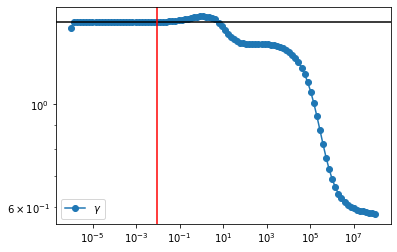

In [16]:
idx = 28
# plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
# plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

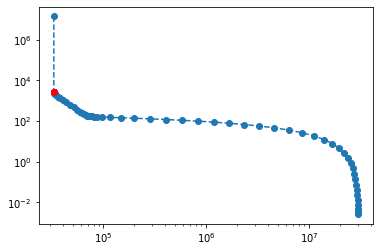

In [17]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

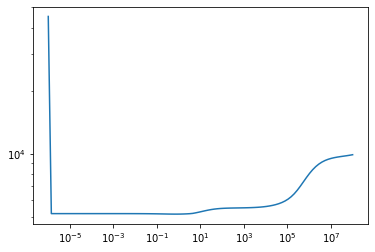

In [18]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

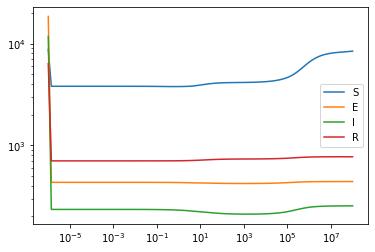

In [19]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIR")

In [22]:
# applying the final size relation
from scipy.optimize import brentq
# def rinf(sol):
#     pfin = np.array([float(p) for p in getp(sol['x'])])
#     r0 = pfin[1]/pfin[0]
#     S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
#     N = sum((S0, E0, I0, R0))
#     f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
#     sinf = brentq(f, 0, S0) 
#     return N-sinf

def rinf(sol):
    r0 = 8*getp(sol['x'])
    S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N)
    sinf = brentq(f, 0, S0)
    return N-sinf

(0, 20000)

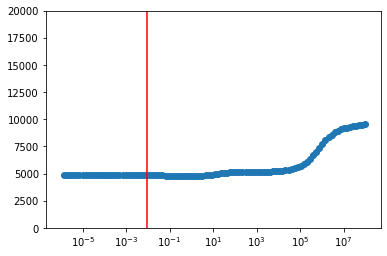

In [23]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])

In [24]:
rinf(sols[idx])

4834.114474753215

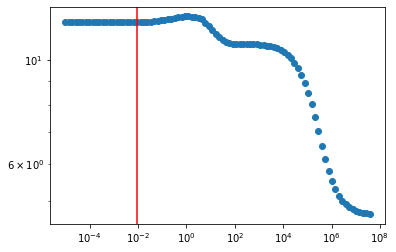

In [25]:
# def r0(sol):
#     pfin = np.array([float(p) for p in getp(sol['x'])])
#     return pfin[1]/pfin[0]
def r0(sol):
    return 8*getp(sol['x'])
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [26]:
[getx(sols[idx]['x'])[i][50] for i in range(4)]

[DM(4467.22), DM(114.223), DM(10.7481), DM(423.824)]

In [27]:
getx(sols[idx]['x'])[0][0]

DM(4786.46)

In [28]:
getp(sols[idx]['x'])

DM(1.50191)

In [29]:
r0(sols[idx])

DM(12.0153)

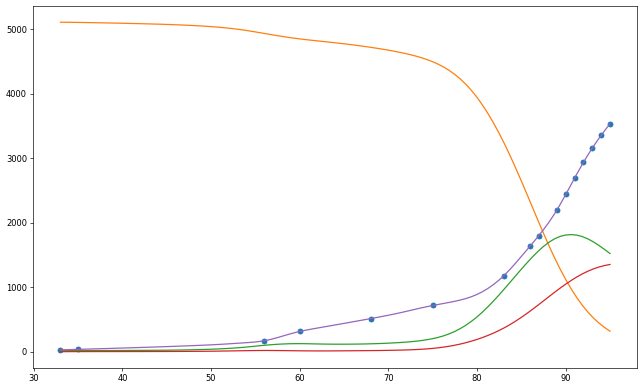

In [31]:
idx = 60
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')


In [33]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'max_iter': 300}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [34]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-2, 1, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), p=[rho, alpha], lbx=lbx0, ubx=ubx0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4656

Total number of variables............................:       96
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   1  1.7158051e+06 0.00e+00 1.14e+01  -1.0 4.04e+03    -  1.00e+00 1.00e+00f  1
   2  1.6781716e+06 0.00e+00 4.57e-01  -1.0 4.32e+03    -  1.00e+00 1.00e+00f  1
   3  1.6651298e+06 0.00e+00 4.33e-01  -1.7 6.41e+03    -  1.00e+00 1.00e+00f  1
   4  1.6650247e+06 0.00e+00 4.12e-03  -1.7 3.99e+01  -4.0 1.00e+00 1.00e+00f  1
   5  1.6649010e+06 0.00e+00 3.73e-03  -3.8 9.74e+01  -4.5 1.00e+00 1.00e+00f  1
   6  1.6646457e+06 0.00e+00 1.47e-02  -3.8 2.37e+02  -5.0 1.00e+00 1.00e+00f  1
   7  1.6640660e+06 0.00e+00 2.76e-01  -3.8 8.25e+02  -5.4 1.00e+00 1.00e+00f  1
   8  1.6631386e+06 0.00e+00 3.37e+00  -3.8 6.91e+03  -5.9 1.00e+00 5.00e-01f  2
   9  1.6596810e+06 0.00e+00 1.16e+00  -3.8 2.18e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6576117e+06 0.00e+00 4.44e+00  -3.8 6.45e+03    -  1.00e+00 5.00e-01f  2
  11  1.6538672e+06 0.00e+00 8.65e-01  -3.8 4.44e+03    -  1.00e+00 1.00e+00f  1
  12  1.6515270e+06 0.00e+00

   5  1.6347242e+06 0.00e+00 2.63e-01  -1.7 3.66e+03    -  1.00e+00 1.00e+00f  1
   6  1.6300176e+06 0.00e+00 3.74e+00  -1.7 8.44e+03    -  1.00e+00 5.00e-01f  2
   7  1.6245997e+06 0.00e+00 9.22e-01  -1.7 7.13e+03    -  1.00e+00 1.00e+00f  1
   8  1.6207328e+06 0.00e+00 1.81e+00  -1.7 1.20e+04    -  1.00e+00 1.00e+00f  1
   9  1.6180127e+06 0.00e+00 5.74e-01  -1.7 1.68e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6161475e+06 0.00e+00 5.23e-01  -1.7 2.62e+04    -  1.00e+00 1.00e+00f  1
  11  1.6148812e+06 0.00e+00 3.04e-01  -1.7 3.90e+04    -  1.00e+00 1.00e+00f  1
  12  1.6140248e+06 0.00e+00 2.05e-01  -1.7 5.86e+04    -  1.00e+00 1.00e+00f  1
  13  1.6134487e+06 0.00e+00 1.35e-01  -1.7 8.79e+04    -  1.00e+00 1.00e+00f  1
  14  1.6130623e+06 0.00e+00 8.97e-02  -2.5 1.32e+05    -  1.00e+00 1.00e+00f  1
  15  1.6128037e+06 0.00e+00 5.97e-02  -2.5 1.98e+05    -  1.00e+00 1.00e+00f  1
  16  1.6126309e+06 0.00e+00

  14  1.5680387e+06 0.00e+00 4.92e-02  -2.5 1.92e+05    -  1.00e+00 1.00e+00f  1
  15  1.5677734e+06 0.00e+00 3.27e-02  -2.5 2.89e+05    -  1.00e+00 1.00e+00f  1
  16  1.5675963e+06 0.00e+00 2.18e-02  -2.5 4.33e+05    -  1.00e+00 1.00e+00f  1
  17  1.5674782e+06 0.00e+00 1.45e-02  -3.8 6.50e+05    -  1.00e+00 1.00e+00f  1
  18  1.5673994e+06 0.00e+00 9.67e-03  -3.8 9.74e+05    -  1.00e+00 1.00e+00f  1
  19  1.5673468e+06 0.00e+00 6.44e-03  -3.8 1.46e+06    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.5673117e+06 0.00e+00 4.30e-03  -3.8 2.19e+06    -  1.00e+00 1.00e+00f  1
  21  1.5672884e+06 0.00e+00 2.86e-03  -3.8 3.29e+06    -  1.00e+00 1.00e+00f  1
  22  1.5672728e+06 0.00e+00 1.92e-03  -3.8 4.95e+06    -  1.00e+00 1.00e+00f  1
  23  1.5672624e+06 0.00e+00 1.26e-03  -3.8 7.37e+06    -  1.00e+00 1.00e+00f  1
  24  1.5672557e+06 0.00e+00 7.79e-04  -5.7 1.05e+07    -  1.00e+00 1.00e+00f  1
  25  1.5672515e+06 0.00e+00

  11  1.5051583e+06 0.00e+00 1.12e-01  -2.5 6.81e+04    -  1.00e+00 1.00e+00f  1
  12  1.5040376e+06 0.00e+00 7.44e-02  -2.5 1.02e+05    -  1.00e+00 1.00e+00f  1
  13  1.5032882e+06 0.00e+00 4.94e-02  -2.5 1.53e+05    -  1.00e+00 1.00e+00f  1
  14  1.5027877e+06 0.00e+00 3.32e-02  -2.5 2.30e+05    -  1.00e+00 1.00e+00f  1
  15  1.5024535e+06 0.00e+00 2.22e-02  -2.5 3.45e+05    -  1.00e+00 1.00e+00f  1
  16  1.5022306e+06 0.00e+00 1.49e-02  -3.8 5.17e+05    -  1.00e+00 1.00e+00f  1
  17  1.5020818e+06 0.00e+00 9.95e-03  -3.8 7.75e+05    -  1.00e+00 1.00e+00f  1
  18  1.5019826e+06 0.00e+00 6.64e-03  -3.8 1.16e+06    -  1.00e+00 1.00e+00f  1
  19  1.5019165e+06 0.00e+00 4.43e-03  -3.8 1.74e+06    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.5018724e+06 0.00e+00 2.96e-03  -3.8 2.62e+06    -  1.00e+00 1.00e+00f  1
  21  1.5018430e+06 0.00e+00 1.98e-03  -3.8 3.93e+06    -  1.00e+00 1.00e+00f  1
  22  1.5018233e+06 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.4584472e+06 0.00e+00 4.47e-08  -8.6 1.14e-03  -8.3 1.00e+00 3.05e-05f 16
  41  1.4584472e+06 0.00e+00 9.12e-08  -8.6 3.43e-03  -8.8 1.00e+00 2.50e-01f  3
  42  1.4584472e+06 0.00e+00 9.12e-08  -8.6 1.03e-02  -9.2 1.00e+00 3.81e-06f 19
  43  1.4584472e+06 0.00e+00 9.12e-08  -8.6 3.08e-02  -9.7 1.00e+00 1.91e-06f 20
  44  1.4584472e+06 0.00e+00 4.36e-08  -8.6 9.25e-02 -10.2 1.00e+00 1.25e-01f  4
  45  1.4584472e+06 0.00e+00 4.61e-08  -8.6 2.78e-01 -10.7 1.00e+00 1.00e+00w  1

Number of Iterations....: 45

                                   (scaled)                 (unscaled)
Objective...............:   8.6372951667727946e+04    1.4584472171752031e+06
Dual infeasibility......:   4.6062995821568227e-08    7.7779497833023833e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error......

  11  1.3485833e+06 0.00e+00 1.83e-01  -1.7 7.46e+04    -  1.00e+00 1.00e+00f  1
  12  1.3466886e+06 0.00e+00 1.24e-01  -2.5 1.12e+05    -  1.00e+00 1.00e+00f  1
  13  1.3454209e+06 0.00e+00 8.40e-02  -2.5 1.68e+05    -  1.00e+00 1.00e+00f  1
  14  1.3445737e+06 0.00e+00 5.65e-02  -2.5 2.52e+05    -  1.00e+00 1.00e+00f  1
  15  1.3440081e+06 0.00e+00 3.79e-02  -2.5 3.78e+05    -  1.00e+00 1.00e+00f  1
  16  1.3436305e+06 0.00e+00 2.53e-02  -2.5 5.66e+05    -  1.00e+00 1.00e+00f  1
  17  1.3433787e+06 0.00e+00 1.69e-02  -3.8 8.50e+05    -  1.00e+00 1.00e+00f  1
  18  1.3432107e+06 0.00e+00 1.13e-02  -3.8 1.27e+06    -  1.00e+00 1.00e+00f  1
  19  1.3430986e+06 0.00e+00 7.55e-03  -3.8 1.91e+06    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3430239e+06 0.00e+00 5.04e-03  -3.8 2.87e+06    -  1.00e+00 1.00e+00f  1
  21  1.3429741e+06 0.00e+00 3.36e-03  -3.8 4.30e+06    -  1.00e+00 1.00e+00f  1
  22  1.3429410e+06 0.00e+00

  15  1.1795926e+06 0.00e+00 5.75e-02  -2.5 3.92e+05    -  1.00e+00 1.00e+00f  1
  16  1.1790579e+06 0.00e+00 3.85e-02  -2.5 5.88e+05    -  1.00e+00 1.00e+00f  1
  17  1.1787010e+06 0.00e+00 2.58e-02  -2.5 8.82e+05    -  1.00e+00 1.00e+00f  1
  18  1.1784630e+06 0.00e+00 1.72e-02  -3.8 1.32e+06    -  1.00e+00 1.00e+00f  1
  19  1.1783042e+06 0.00e+00 1.15e-02  -3.8 1.98e+06    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1781983e+06 0.00e+00 7.68e-03  -3.8 2.98e+06    -  1.00e+00 1.00e+00f  1
  21  1.1781277e+06 0.00e+00 5.11e-03  -3.8 4.46e+06    -  1.00e+00 1.00e+00f  1
  22  1.1780805e+06 0.00e+00 3.43e-03  -3.8 6.72e+06    -  1.00e+00 1.00e+00f  1
  23  1.1780494e+06 0.00e+00 2.24e-03  -3.8 9.96e+06    -  1.00e+00 1.00e+00f  1
  24  1.1780282e+06 0.00e+00 1.55e-03  -3.8 1.52e+07    -  1.00e+00 1.00e+00f  1
  25  1.1780129e+06 0.00e+00 1.29e-03  -3.8 2.63e+07    -  1.00e+00 1.00e+00f  1
  26  1.1780166e+06 0.00e+00

  23  1.0745785e+06 0.00e+00 2.90e-03  -3.8 1.02e+07    -  1.00e+00 1.00e+00f  1
  24  1.0745535e+06 0.00e+00 2.01e-03  -3.8 1.57e+07    -  1.00e+00 1.00e+00f  1
  25  1.0745386e+06 0.00e+00 1.03e-03  -3.8 2.04e+07    -  1.00e+00 1.00e+00f  1
  26  1.0745297e+06 0.00e+00 5.03e-04  -5.7 2.40e+07    -  1.00e+00 1.00e+00f  1
  27  1.0745248e+06 0.00e+00 1.91e-04  -5.7 2.25e+07    -  1.00e+00 1.00e+00f  1
  28  1.0745226e+06 0.00e+00 4.19e-05  -5.7 1.39e+07    -  1.00e+00 1.00e+00f  1
  29  1.0745226e+06 0.00e+00 7.45e-08  -5.7 7.47e-04  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0745143e+06 0.00e+00 1.14e-03  -8.6 1.12e+08    -  1.00e+00 1.00e+00f  1
  31  1.0745143e+06 0.00e+00 7.06e-07  -8.6 2.07e-02  -4.5 1.00e+00 1.00e+00f  1
  32  1.0745143e+06 0.00e+00 1.23e-08  -8.6 2.60e-04  -5.0 1.00e+00 1.00e+00f  1
  33  1.0745097e+06 0.00e+00 7.22e-04  -9.0 2.38e+08    -  1.00e+00 1.00e+00f  1
  34  1.0745097e+06 0.00e+00

  45  9.5794016e+05 0.00e+00 6.31e-08  -9.0 8.32e-02  -9.7 1.00e+00 6.25e-02f  5
  46  9.5794016e+05 0.00e+00 6.31e-08  -9.0 2.50e-01 -10.2 1.00e+00 2.38e-07f 23
  47  9.5794016e+05 0.00e+00 3.79e-08  -9.0 7.49e-01 -10.7 1.00e+00 2.50e-01f  3
  48  9.5794016e+05 0.00e+00 2.65e-08  -9.0 2.25e+00 -11.2 1.00e+00 1.00e+00F  1
  49  9.5794016e+05 0.00e+00 6.48e-08  -9.0 6.74e+00 -11.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  9.5794016e+05 0.00e+00 3.01e-08  -9.0 2.02e+01 -12.1 1.00e+00 1.00e+00f  1
  51  9.5794016e+05 0.00e+00 4.62e-08  -9.0 6.07e+01 -12.6 1.00e+00 1.00e+00f  1
  52  9.5794016e+05 0.00e+00 8.10e-08  -9.0 1.82e+02 -13.1 1.00e+00 1.00e+00f  1
  53  9.5794016e+05 0.00e+00 6.13e-08  -9.0 5.46e+02 -13.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:   5.8227903960943418e+04    9.5794016008054384e+05
Dual infeas

   6  7.8767075e+05 0.00e+00 2.83e+00  -1.0 1.05e+04    -  1.00e+00 1.00e+00f  1
   7  7.6066929e+05 0.00e+00 2.27e+00  -1.0 1.54e+04    -  1.00e+00 1.00e+00f  1
   8  7.4186286e+05 0.00e+00 1.75e+00  -1.0 2.26e+04    -  1.00e+00 1.00e+00f  1
   9  7.2884192e+05 0.00e+00 1.31e+00  -1.0 3.36e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.1988679e+05 0.00e+00 9.61e-01  -1.0 5.00e+04    -  1.00e+00 1.00e+00f  1
  11  7.1376858e+05 0.00e+00 6.86e-01  -1.7 7.47e+04    -  1.00e+00 1.00e+00f  1
  12  7.0961339e+05 0.00e+00 4.82e-01  -1.7 1.12e+05    -  1.00e+00 1.00e+00f  1
  13  7.0680532e+05 0.00e+00 3.33e-01  -1.7 1.67e+05    -  1.00e+00 1.00e+00f  1
  14  7.0491499e+05 0.00e+00 2.28e-01  -1.7 2.51e+05    -  1.00e+00 1.00e+00f  1
  15  7.0364617e+05 0.00e+00 1.55e-01  -1.7 3.76e+05    -  1.00e+00 1.00e+00f  1
  16  7.0279631e+05 0.00e+00 1.05e-01  -2.5 5.64e+05    -  1.00e+00 1.00e+00f  1
  17  7.0222792e+05 0.00e+00

   7  5.3899436e+05 0.00e+00 3.62e+00  -1.0 9.56e+03    -  1.00e+00 1.00e+00f  1
   8  5.1512256e+05 0.00e+00 3.02e+00  -1.0 1.36e+04    -  1.00e+00 1.00e+00f  1
   9  4.9826988e+05 0.00e+00 2.44e+00  -1.0 1.95e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.8638290e+05 0.00e+00 1.92e+00  -1.0 2.84e+04    -  1.00e+00 1.00e+00f  1
  11  4.7803312e+05 0.00e+00 1.47e+00  -1.0 4.17e+04    -  1.00e+00 1.00e+00f  1
  12  4.7220485e+05 0.00e+00 1.11e+00  -1.0 6.16e+04    -  1.00e+00 1.00e+00f  1
  13  4.6816699e+05 0.00e+00 8.11e-01  -1.0 9.15e+04    -  1.00e+00 1.00e+00f  1
  14  4.6539092e+05 0.00e+00 5.82e-01  -1.7 1.37e+05    -  1.00e+00 1.00e+00f  1
  15  4.6349587e+05 0.00e+00 4.11e-01  -1.7 2.04e+05    -  1.00e+00 1.00e+00f  1
  16  4.6221008e+05 0.00e+00 2.86e-01  -1.7 3.06e+05    -  1.00e+00 1.00e+00f  1
  17  4.6134192e+05 0.00e+00 1.96e-01  -1.7 4.58e+05    -  1.00e+00 1.00e+00f  1
  18  4.6075792e+05 0.00e+00

  29  3.6445444e+05 0.00e+00 8.72e-05  -5.7 1.12e+07    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.6445253e+05 0.00e+00 2.24e-04  -5.7 2.10e+07    -  1.00e+00 1.00e+00f  1
  31  3.6445205e+05 0.00e+00 1.48e-05  -5.7 6.36e+06    -  1.00e+00 1.00e+00f  1
  32  3.6445173e+05 0.00e+00 6.90e-06  -8.6 4.58e+06    -  1.00e+00 1.00e+00f  1
  33  3.6445102e+05 0.00e+00 3.56e-05  -8.6 1.11e+07    -  1.00e+00 1.00e+00f  1
  34  3.6445102e+05 0.00e+00 1.97e-08  -8.6 2.33e-04  -4.5 1.00e+00 1.00e+00f  1
  35  3.6444885e+05 0.00e+00 4.12e-04  -9.0 4.49e+07    -  1.00e+00 1.00e+00f  1
  36  3.6444865e+05 0.00e+00 3.83e-06  -9.0 5.50e+06    -  1.00e+00 1.00e+00f  1
  37  3.6444865e+05 0.00e+00 3.83e-06  -9.0 3.35e-05  -5.0 1.00e+00 2.44e-04f 13
  38  3.6444865e+05 0.00e+00 2.44e-08  -9.0 5.11e-05  -5.4 1.00e+00 1.00e+00f  1
  39  3.6444865e+05 0.00e+00 2.20e-08  -9.0 7.90e-05  -5.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

  16  2.5268735e+05 0.00e+00 8.73e-01  -1.0 4.96e+04    -  1.00e+00 1.00e+00f  1
  17  2.5206238e+05 0.00e+00 7.24e-01  -1.7 6.83e+04    -  1.00e+00 1.00e+00f  1
  18  2.5160256e+05 0.00e+00 5.96e-01  -1.7 9.53e+04    -  1.00e+00 1.00e+00f  1
  19  2.5126474e+05 0.00e+00 4.84e-01  -1.7 1.35e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.5101764e+05 0.00e+00 3.87e-01  -1.7 1.92e+05    -  1.00e+00 1.00e+00f  1
  21  2.5083815e+05 0.00e+00 3.04e-01  -1.7 2.78e+05    -  1.00e+00 1.00e+00f  1
  22  2.5070894e+05 0.00e+00 2.34e-01  -1.7 4.06e+05    -  1.00e+00 1.00e+00f  1
  23  2.5061692e+05 0.00e+00 1.77e-01  -1.7 5.98e+05    -  1.00e+00 1.00e+00f  1
  24  2.5055210e+05 0.00e+00 1.31e-01  -2.5 8.85e+05    -  1.00e+00 1.00e+00f  1
  25  2.5050695e+05 0.00e+00 9.47e-02  -2.5 1.32e+06    -  1.00e+00 1.00e+00f  1
  26  2.5047579e+05 0.00e+00 6.75e-02  -2.5 1.97e+06    -  1.00e+00 1.00e+00f  1
  27  2.5045450e+05 0.00e+00

  13  2.1490975e+05 0.00e+00 2.09e-03  -2.5 1.22e+02    -  1.00e+00 1.00e+00f  1
  14  2.1490975e+05 0.00e+00 3.91e-06  -3.8 5.30e+00    -  1.00e+00 1.00e+00f  1
  15  2.1490975e+05 0.00e+00 2.56e-11  -8.6 9.82e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   1.0570040886720941e+04    2.1490974741911475e+05
Dual infeasibility......:   2.5575662966466244e-11    5.2000359573867172e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.5575662966466244e-11    5.2000359573867172e-10


Number of objective function evaluations             = 23
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian

   6  1.7438917e+05 0.00e+00 1.39e-01  -1.7 2.55e+02    -  1.00e+00 1.00e+00f  1
   7  1.7437130e+05 0.00e+00 5.82e-03  -2.5 5.29e+01    -  1.00e+00 1.00e+00f  1
   8  1.7437125e+05 0.00e+00 2.35e-05  -3.8 3.37e+00    -  1.00e+00 1.00e+00f  1
   9  1.7437125e+05 0.00e+00 2.08e-10  -5.7 1.00e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   6.8292381070593183e+03    1.7437124749282075e+05
Dual infeasibility......:   2.0809879260658965e-10    5.3133959454498836e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.0809879260658965e-10    5.3133959454498836e-09


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 0
Number of inequ

  12  1.4245163e+05 0.00e+00 1.40e-08  -9.0 6.20e-07    -  1.00e+00 1.22e-04f 14
  13  1.4245163e+05 0.00e+00 1.40e-08  -9.0 6.19e-07    -  1.00e+00 1.22e-04f 14
  14  1.4245163e+05 0.00e+00 1.40e-08  -9.0 6.19e-07    -  1.00e+00 1.22e-04f 14
  15  1.4245163e+05 0.00e+00 1.40e-08  -9.0 6.19e-07    -  1.00e+00 1.22e-04f 14
  16  1.4245163e+05 0.00e+00 2.88e-11  -9.0 6.19e-07    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   5.4450693220336170e+03    1.4245162743265912e+05
Dual infeasibility......:   2.8843683309110319e-11    7.5459638537722640e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.8843683309110319e-11    7.5459638537722640e-10


Number of objective function evaluations             = 168
Number of objective gradient evaluations       

   3  1.3688346e+05 0.00e+00 3.46e+00  -1.0 3.08e+01  -1.0 1.00e+00 1.00e+00f  1
   4  1.2944501e+05 0.00e+00 3.40e+00  -1.0 1.09e+03    -  1.00e+00 2.50e-01f  3
   5  1.2665760e+05 0.00e+00 3.79e-01  -1.0 8.70e+01    -  1.00e+00 1.00e+00f  1
   6  1.2664866e+05 0.00e+00 1.83e-03  -1.7 7.94e+00    -  1.00e+00 1.00e+00f  1
   7  1.2664865e+05 0.00e+00 2.42e-06  -3.8 2.09e-01    -  1.00e+00 1.00e+00f  1
   8  1.2664865e+05 0.00e+00 4.22e-11  -8.6 6.54e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   5.2789136170000893e+03    1.2664865351207959e+05
Dual infeasibility......:   4.2178974396692518e-11    1.0119336479874619e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.2178974396692518e-11    1.0119336479874619e-09


Number of objective functi

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4978364e+05 0.00e+00 8.23e-07  -3.8 1.91e-01    -  1.00e+00 1.00e+00f  1
  11  1.4978364e+05 0.00e+00 2.22e-12  -8.6 2.30e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   9.4310401080259010e+02    1.4978364459497121e+05
Dual infeasibility......:   2.2233448860957600e-12    3.5311131796333939e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.2233448860957600e-12    3.5311131796333939e-10


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian

   8  2.6560963e+05 0.00e+00 1.59e+00  -2.5 7.44e+03    -  1.00e+00 6.25e-02f  5
   9  1.9606524e+05 0.00e+00 8.10e-02  -2.5 6.58e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9429854e+05 0.00e+00 3.08e-01  -2.5 1.78e+02    -  1.00e+00 1.00e+00f  1
  11  1.9366823e+05 0.00e+00 9.69e-04  -2.5 1.19e+01    -  1.00e+00 1.00e+00f  1
  12  1.9366749e+05 0.00e+00 8.05e-05  -5.7 2.52e+00    -  1.00e+00 1.00e+00f  1
  13  1.9366749e+05 0.00e+00 1.14e-10  -5.7 3.97e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   3.6739559968717043e+02    1.9366748613458834e+05
Dual infeasibility......:   1.1402235662977117e-10    6.0105301180612969e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error......

   1  7.4096373e+07 0.00e+00 7.60e+01  -1.0 7.68e+01   0.0 1.00e+00 1.00e+00f  1
   2  3.8848134e+07 0.00e+00 4.65e+01  -1.0 1.43e+02  -0.5 1.00e+00 1.00e+00f  1
   3  1.5058699e+07 0.00e+00 1.95e+01  -1.0 1.85e+02  -1.0 1.00e+00 1.00e+00f  1
   4  4.5274378e+06 0.00e+00 7.82e+00  -1.0 2.20e+02  -1.4 1.00e+00 1.00e+00f  1
   5  1.3373073e+06 0.00e+00 2.21e+00  -1.0 1.56e+02  -1.9 1.00e+00 1.00e+00f  1
   6  6.8414327e+05 0.00e+00 5.81e-01  -1.0 1.36e+02  -2.4 1.00e+00 1.00e+00f  1
   7  5.0620282e+05 0.00e+00 1.38e-01  -1.7 1.05e+02  -2.9 1.00e+00 1.00e+00f  1
   8  4.2068379e+05 0.00e+00 9.01e-02  -2.5 1.21e+02  -3.3 1.00e+00 1.00e+00f  1
   9  3.5599173e+05 0.00e+00 4.76e-01  -2.5 3.55e+02  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6220089e+05 0.00e+00 3.57e-01  -2.5 1.08e+03    -  1.00e+00 1.00e+00f  1
  11  2.5214636e+05 0.00e+00 8.45e-02  -2.5 7.23e+01    -  1.00e+00 1.00e+00f  1
  12  2.5090143e+05 0.00e+00

   5  3.5755372e+06 0.00e+00 2.48e+00  -1.0 1.87e+02  -1.9 1.00e+00 1.00e+00f  1
   6  1.3539717e+06 0.00e+00 7.71e-01  -1.0 1.65e+02  -2.4 1.00e+00 1.00e+00f  1
   7  8.8704635e+05 0.00e+00 1.66e-01  -1.7 1.16e+02  -2.9 1.00e+00 1.00e+00f  1
   8  6.9824182e+05 0.00e+00 5.37e-02  -2.5 1.18e+02  -3.3 1.00e+00 1.00e+00f  1
   9  6.0688124e+05 0.00e+00 4.26e-02  -2.5 1.46e+02  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.6526490e+05 0.00e+00 2.79e-01  -2.5 4.97e+03  -4.3 1.00e+00 6.25e-02f  5
  11  4.4023346e+05 0.00e+00 5.32e-01  -2.5 1.29e+03    -  1.00e+00 5.00e-01f  2
  12  3.2737587e+05 0.00e+00 3.77e-02  -2.5 5.40e+02    -  1.00e+00 1.00e+00f  1
  13  3.2289093e+05 0.00e+00 7.58e-02  -2.5 1.78e+02    -  1.00e+00 1.00e+00f  1
  14  3.2252713e+05 0.00e+00 4.31e-04  -2.5 1.21e+01    -  1.00e+00 1.00e+00f  1
  15  3.2252661e+05 0.00e+00 5.05e-06  -5.7 1.04e+00    -  1.00e+00 1.00e+00f  1
  16  3.2252661e+05 0.00e+00

In [35]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

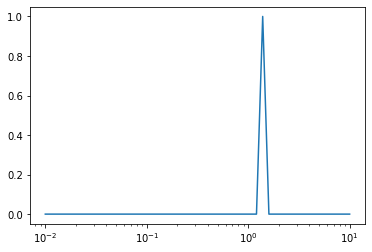

In [40]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.semilogx(np.logspace(-2, 1, num=50).flatten(), f0r)

In [37]:
list(zip(range(50), np.logspace(-2, 1, num=50),f0r))

[(0, 0.01, DM(0)),
 (1, 0.011513953993264475, DM(0)),
 (2, 0.013257113655901088, DM(0)),
 (3, 0.015264179671752334, DM(0)),
 (4, 0.017575106248547922, DM(0)),
 (5, 0.020235896477251575, DM(0)),
 (6, 0.023299518105153717, DM(0)),
 (7, 0.02682695795279726, DM(0)),
 (8, 0.030888435964774818, DM(0)),
 (9, 0.03556480306223128, DM(0)),
 (10, 0.040949150623804255, DM(0)),
 (11, 0.04714866363457394, DM(0)),
 (12, 0.054286754393238594, DM(0)),
 (13, 0.06250551925273973, DM(0)),
 (14, 0.07196856730011521, DM(0)),
 (15, 0.08286427728546843, DM(0)),
 (16, 0.09540954763499938, DM(0)),
 (17, 0.10985411419875583, DM(0)),
 (18, 0.12648552168552957, DM(0)),
 (19, 0.14563484775012436, DM(0)),
 (20, 0.16768329368110083, DM(0)),
 (21, 0.19306977288832497, DM(0)),
 (22, 0.22229964825261944, DM(0)),
 (23, 0.2559547922699536, DM(0)),
 (24, 0.29470517025518095, DM(0)),
 (25, 0.3393221771895328, DM(0)),
 (26, 0.3906939937054617, DM(0)),
 (27, 0.44984326689694465, DM(0)),
 (28, 0.517947467923121, DM(0)),
 (29, 

In [ ]:
a0 = linterp(0.011513953993264475, 0.013257113655901088, 0.145754, 0.152931, 0.15)
a1 = linterp( 0.2559547922699536, 0.29470517025518095, 0.314558, 0.115928,  0.15)
a0idx = [1, 2]
a1idx = [23, 24]

In [38]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.plot(np.logspace(-2, 1, num=50).flatten(), f1r)

IndexError: list index out of range

In [ ]:
list(zip(range(50), np.logspace(-2, 1, num=50),f1r))

In [ ]:
b0 = linterp(0.6866488450043002, 0.7906043210907697,0.105638 , 0.158776, 0.15)
b1 = linterp(2.8117686979742306,2.8117686979742308, 0.149, 0.151, 0.15)
b0idx = [30, 31]
b1idx = [40, 40]

In [ ]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

In [ ]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [ ]:
def rinf(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinf(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

In [41]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(np.logspace(-2, 1, num=50).flatten()[:25], f2[:25])

IndexError: list index out of range

In [42]:
from scipy.integrate import solve_ivp
idx = 70
tidx = 65
tidxb = 30
print(model.observation_times[tidx])
sol = solve_ivp(lambda t,y: seir(t, y, getp(sols[idx]['x'])), [0, 60], [getx(sols[idx]['x'])[i][tidx] for i in range(4)], dense_output=True)
solb = solve_ivp(lambda t,y: np.array(seir(t, y, getp(sols[idx]['x']))), [0, 200], [getx(sols[idx]['x'])[i][tidxb] for i in range(4)], dense_output=True)

73.70707070707071


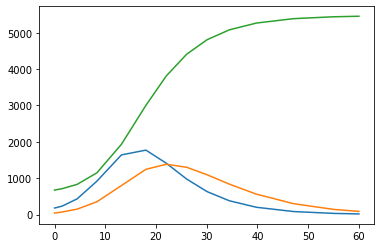

In [43]:
plt.plot(sol.t, sol.y[1:,:].T)

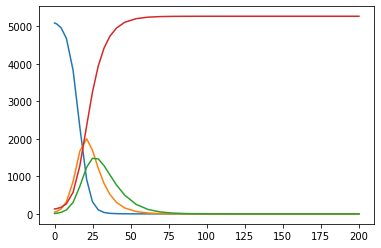

In [44]:
plt.plot(solb.t, solb.y.T)

In [45]:
model.observation_times[-1]

95.0

Text(0.5, 1.0, 'Number of Reported Cases (Prediction)')

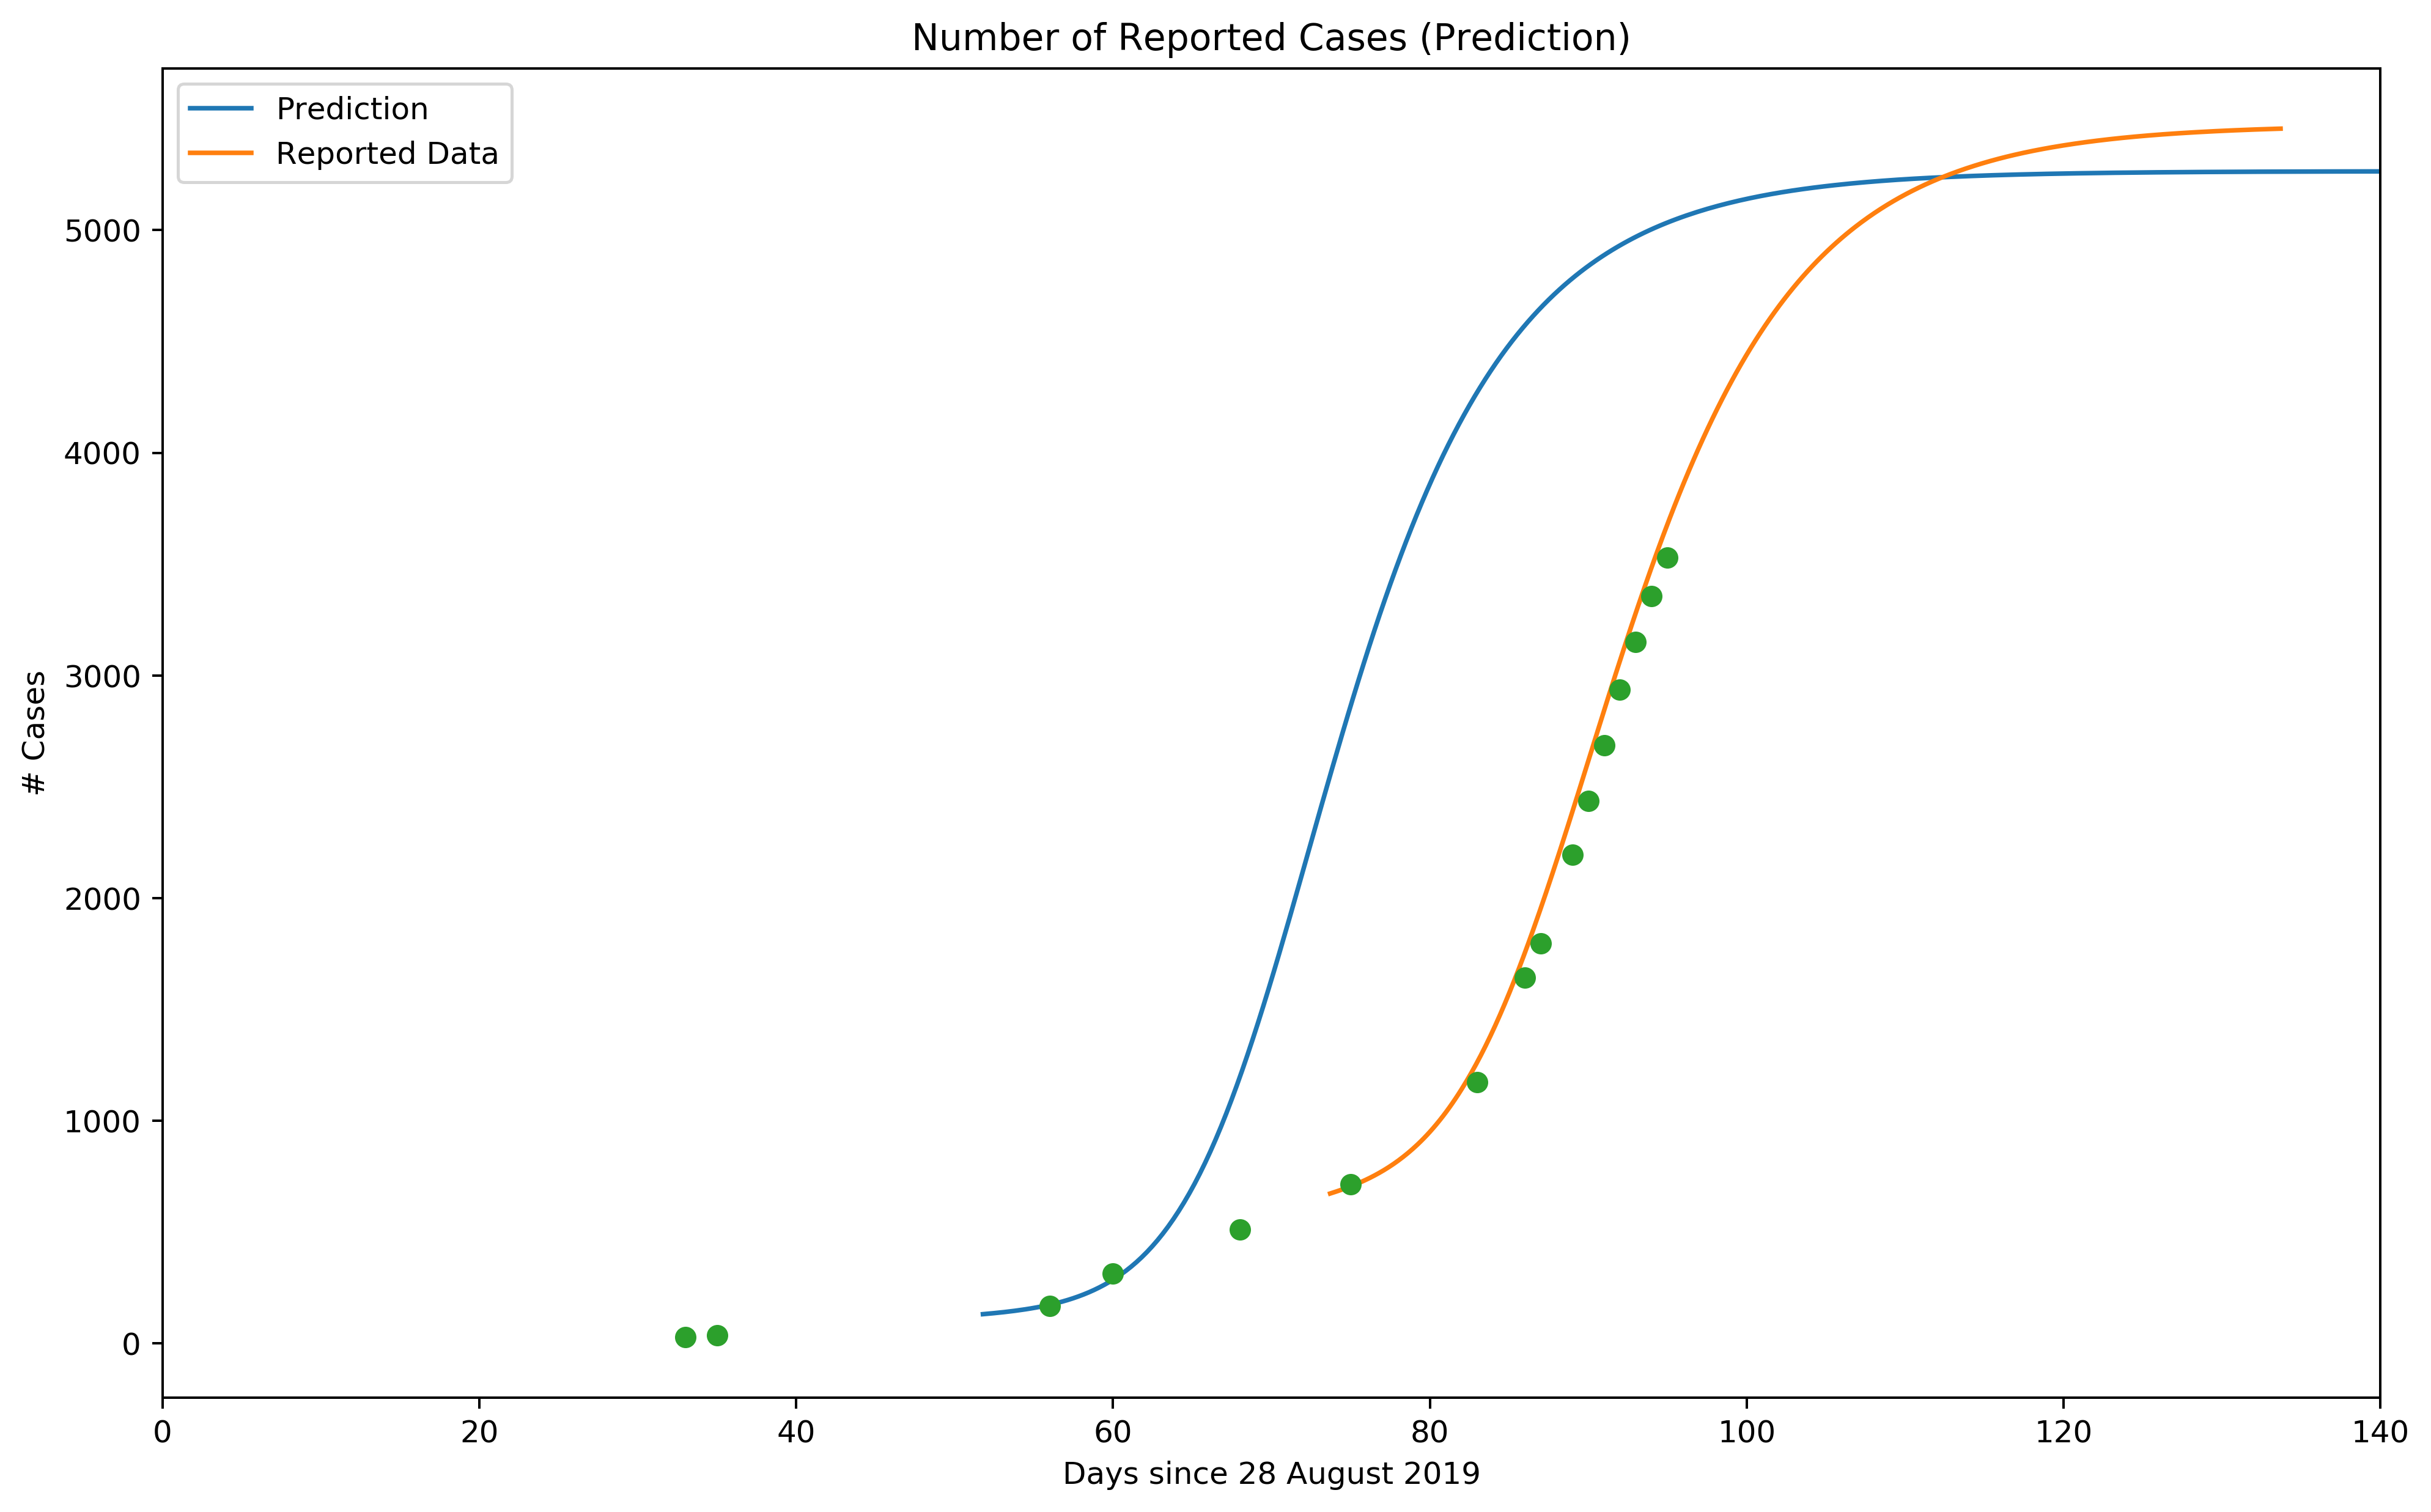

In [46]:
tfine = np.linspace(0, 60, 600)
tbfine = np.linspace(0, 200, 600)
plt.figure(figsize=[13, 8], dpi=360)
plt.plot(tbfine+model.observation_times[tidxb], solb.sol(tbfine)[-1,:].T)
plt.plot(tfine+model.observation_times[tidx], sol.sol(tfine)[-1,:].T)
plt.plot(times, cumdata, 'o')
plt.xlim(0, 140)
plt.legend(["Prediction", "Reported Data"])
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

In [47]:
rfin = sol.sol(tfine)[-1,-1]

In [48]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [49]:
tfine[ridx]

36.961602671118534

In [50]:
tfine[ridx]-(model.observation_times[-1]-model.observation_times[tidx])

15.668673378189247

In [51]:
model.observation_times[-1]-model.observation_times[tidx]

21.292929292929287

In [52]:
historical_mortality = 0.02
current_mortality = 39/2936
print(historical_mortality, current_mortality)

0.02 0.013283378746594006


In [53]:
rfin*historical_mortality

109.10997854196265

In [54]:
rfin*current_mortality

72.46745850028174